# Packages and Helper Functions

In [58]:
import warnings
warnings.filterwarnings("ignore")
import os

import pandas as pd
import numpy as np
import polars as pl
import scipy.stats as stats
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import GroupKFold, KFold, train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score, median_absolute_error, classification_report, mean_absolute_error, roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from scipy.optimize import minimize

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression

import optuna

import requests
import re
import tabula
import pdfplumber

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.float_format', lambda x: "%.4f" % x)
# pd.options.plotting.backend = "plotly"

plt.style.use('ggplot')
sns.set_style('darkgrid')

# Reading in Data

## Pulling PDFs

In [2]:
isu_url = "https://results.isu.org/results/season2122/owg2022/"

# Get the HTML content of the page
response = requests.get(isu_url)
html_content = response.text

regex_pattern = r'href=([^\s>]+\.pdf)'

# Find all matches
matches = re.findall(regex_pattern, html_content, re.IGNORECASE)

print(matches)
print(len(matches))

['FSKMSINGLES-----------QUAL000100--_JudgesDetailsperSkater.pdf', 'FSKMSINGLES-----------FNL-000100--_JudgesDetailsperSkater.pdf', 'FSKWSINGLES-----------QUAL000100--_JudgesDetailsperSkater.pdf', 'FSKWSINGLES-----------FNL-000100--_JudgesDetailsperSkater.pdf', 'FSKXPAIRS-------------QUAL000100--_JudgesDetailsperSkater.pdf', 'FSKXPAIRS-------------FNL-000100--_JudgesDetailsperSkater.pdf', 'FSKXICEDANCE----------QUAL000100--_JudgesDetailsperSkater.pdf', 'FSKXICEDANCE----------FNL-000100--_JudgesDetailsperSkater.pdf', 'FSKXTEAM--------------------------_EntryListbyEvent.pdf', 'FSKXTEAM--------------QUAL0001MN--_JudgesDetailsperSkater.pdf', 'FSKXTEAM--------------FNL-0001MN--_JudgesDetailsperSkater.pdf', 'FSKXTEAM--------------QUAL0002LD--_JudgesDetailsperSkater.pdf', 'FSKXTEAM--------------FNL-0002LD--_JudgesDetailsperSkater.pdf', 'FSKXTEAM--------------QUAL0003PR--_JudgesDetailsperSkater.pdf', 'FSKXTEAM--------------FNL-0003PR--_JudgesDetailsperSkater.pdf', 'FSKXTEAM--------------QUAL000

In [3]:
score_sheet_file_names = [m for m in matches if "judge" in m.lower()]
score_sheet_urls = [isu_url + m for m in score_sheet_file_names]
print(score_sheet_urls)
print(len(score_sheet_urls))

['https://results.isu.org/results/season2122/owg2022/FSKMSINGLES-----------QUAL000100--_JudgesDetailsperSkater.pdf', 'https://results.isu.org/results/season2122/owg2022/FSKMSINGLES-----------FNL-000100--_JudgesDetailsperSkater.pdf', 'https://results.isu.org/results/season2122/owg2022/FSKWSINGLES-----------QUAL000100--_JudgesDetailsperSkater.pdf', 'https://results.isu.org/results/season2122/owg2022/FSKWSINGLES-----------FNL-000100--_JudgesDetailsperSkater.pdf', 'https://results.isu.org/results/season2122/owg2022/FSKXPAIRS-------------QUAL000100--_JudgesDetailsperSkater.pdf', 'https://results.isu.org/results/season2122/owg2022/FSKXPAIRS-------------FNL-000100--_JudgesDetailsperSkater.pdf', 'https://results.isu.org/results/season2122/owg2022/FSKXICEDANCE----------QUAL000100--_JudgesDetailsperSkater.pdf', 'https://results.isu.org/results/season2122/owg2022/FSKXICEDANCE----------FNL-000100--_JudgesDetailsperSkater.pdf', 'https://results.isu.org/results/season2122/owg2022/FSKXTEAM-----------

In [4]:
dir_name = "/Users/kylewang/Documents/yale/SDS4250_StatCaseStudies/OlympicFigureSkating/2022oly_score_sheets"
# if dir_name exists, skip this
if os.path.isdir(dir_name):
    print(f"data directory already exists: {dir_name}")
else:
    print(f"making data directory: {dir_name}")
    os.makedirs(dir_name, exist_ok=True)

    for url in score_sheet_urls:
        response = requests.get(url)
        filename = url.split('/')[-1]
        filepath = os.path.join(dir_name, filename)
        with open(filepath, 'wb') as f:
            f.write(response.content)
        print(f"Downloaded: {filename}")

data directory already exists: /Users/kylewang/Documents/yale/SDS4250_StatCaseStudies/OlympicFigureSkating/2022oly_score_sheets


## Regex Parsing of PDFs

In [5]:
PDF_PATH = dir_name + "/FSKMSINGLES-----------QUAL000100--_JudgesDetailsperSkater.pdf"
OUTPUT_CSV = dir_name + "/executed_elements.csv"

pages_text = []
with pdfplumber.open(PDF_PATH) as pdf:
    for page in pdf.pages:
        text = page.extract_text()
        if text:
            pages_text.append(text)

full_text = "\n".join(pages_text)
# full_text = full_text.replace(" x ", " ")

skater_header_pattern = re.compile(
    r"""
    ^(\d+)\s+                  # 1 rank
    (.+?)\s+                   # 2 name
    ([A-Z]{3})\s+              # 3 NOC code
    (\d+)\s+                   # 4 starting num
    (\d+\.\d{2})\s+            # 5 total segment score
    (\d+\.\d{2})\s+            # 6 total element score
    (\d+\.\d{2})\s+            # 7 total program score
    (-?\d+\.\d{2})$            # 8 total deductions
    """,
    re.VERBOSE | re.MULTILINE
)

element_pattern = re.compile(
    r"""
    ^\s*(\d+)\s+                 # 1 element number
    ([A-Za-z0-9+!*<>q]+)\s+      # 2 element code
    (?:(\S+)\s+)?                # 3 optional info column (x, q, !, etc.)
    ([\d.]+)\s+                  # 4 base value
    (?:\b(x)\b\s+)?              # 5 optional extra points column (x)
    ([\-\d.]+)\s+                # 6 GOE
    ((?:(?:-?\d+)|-)(?:\s+(?:(?:-?\d+)|-)){8}\s+)  # 7 judges scores 
    ([\d.]+)$                    # 8 final score
    """,
    re.VERBOSE | re.MULTILINE
)

program_components_pattern = re.compile(
    r"""
    ^(Skating\s+Skills|Transitions|Performance|Composition|Interpretation\s+of\s+the\s+Music)\s+  # 1 component
    (\d+\.\d{2})\s+                     # 2 factor
    ((?:\d+\.\d{2}\s+){9})              # 3 judge scores
    (\d+\.\d{2})$                       # 4 final score
    """,
    re.VERBOSE | re.MULTILINE
)


In [6]:
matches = list(skater_header_pattern.finditer(full_text))

skater_blocks = []
for i, m in enumerate(matches):
    start = m.start()
    end = matches[i + 1].start() if i + 1 < len(matches) else len(full_text)
    skater_blocks.append((m, full_text[start:end]))


elements_rows = []
program_rows = []

for header, block in skater_blocks:
    rank = int(header.group(1))
    name = header.group(2).title()
    noc = header.group(3)
    starting_number = int(header.group(4))
    tss = float(header.group(5))
    tes = float(header.group(6))
    tpcs = float(header.group(7))
    deductions = float(header.group(8))

    for m in element_pattern.finditer(block):
        row = {
            "rank": rank,
            "name": name,
            "noc": noc,
            "starting_number": starting_number,
            "tss": tss,
            "tes": tes,
            "tpcs": tpcs,
            "deductions": deductions,
            "element_no": int(m.group(1)),
            "element": m.group(2),
            "info": m.group(3),
            "base_value": float(m.group(4)),
            "extra_points": 1 if m.group(5) else 0,
            "goe": float(m.group(6)),
            "final_score": float(m.group(8)),
        }

        judges = m.group(7).split()
        for i, j in enumerate(judges):
            try:
                row[f"J{i+1}"] = int(j)
            except ValueError:
                row[f"J{i+1}"] = 0
        
        elements_rows.append(row)
    
    for m in program_components_pattern.finditer(block):
        row = {
            "rank": rank,
            "name": name,
            "noc": noc,
            "starting_number": starting_number,
            "tss": tss,
            "tes": tes,
            "tpcs": tpcs,
            "deductions": deductions,
            "program_component": m.group(1),
            "factor": float(m.group(2)),
            "final_score": float(m.group(4)),
        }

        judges = m.group(3).split()
        for i, j in enumerate(judges):
            try:
                row[f"J{i+1}"] = float(j)
            except ValueError:
                row[f"J{i+1}"] = 0
        
        program_rows.append(row)

element_df = pd.DataFrame(elements_rows)
element_df.sort_values(["rank", "element_no"], inplace=True)

program_df = pd.DataFrame(program_rows)
program_df.sort_values(["rank", "program_component"], inplace=True)

# df.to_csv(OUTPUT_CSV, index=False)

# print(f"Saved {len(df)} rows to {OUTPUT_CSV}")

In [7]:
print(full_text)

Capital Indoor Stadium Figure Skating
首都体育馆 花样滑冰 / Patinage artistique
Palais omnisports de la capitale Men Single Skating
男子单人滑 / Patinage individuel hommes
TUE 8 FEB 2022 Short Program
短节目 / Programme court
Judges Details per Skater
裁判员对每位运动员的详细分数 / Notation détaillée des juges par patineur
Total Total Total Program
NOC Starting Total
Rank Name Segment Element Component Score
Code Number Deductions
Score Score (factored)
1 CHEN Nathan USA 28 113.97 65.98 47.99 0.00
# Executed Elements
FSKMSINGLES-----------QUAL000100--_77B v1.0 Report Created TUE 8 FEB 2022 13:33
ofnI Base Scores of GOE J1 J2 J3 J4 J5 J6 J7 J8 J9 Ref.
Value Panel
1 4F 11.00 4.40 4 4 5 4 4 4 4 4 4 15.40
2 3A 8.00 2.29 3 3 3 3 4 2 2 2 4 10.29
3 CCSp4 3.20 1.05 4 4 3 4 3 3 3 3 3 4.25
4 4Lz+3T 17.27 x 3.94 4 4 4 3 4 2 2 3 4 21.21
5 StSq4 3.90 1.95 5 5 5 5 5 5 4 5 5 5.85
6 FSSp4 3.00 1.03 3 4 4 3 4 3 3 3 4 4.03
7 CCoSp4 3.50 1.45 4 4 4 5 4 4 4 5 4 4.95
49.87 65.98
Program Components Factor
Skating Skills 1.00 9.75 9.25 9.

In [8]:
print(element_df.shape)

(203, 24)


In [9]:
element_df["name"].value_counts()

name
Chen Nathan             7
Vasiljevs Deniss        7
Selevko Aleksandr       7
Lee Sihyeong            7
Bychenko Alexei         7
Brezina Michal          7
Britschgi Lukas         7
Mozalev Andrei          7
Shmuratko Ivan          7
Milyukov Konstantin     7
Majorov Nikolaj         7
Carrillo Donovan        7
Litvintsev Vladimir     7
Kerry Brendan           7
Kondratiuk Mark         7
Kagiyama Yuma           7
Siao Him Fa Adam        7
Rizzo Matteo            7
Grassl Daniel           7
Jin Boyang              7
Aymoz Kevin             7
Messing Keegan          7
Hanyu Yuzuru            7
Semenenko Evgeni        7
Brown Jason             7
Kvitelashvili Morisi    7
Cha Junhwan             7
Uno Shoma               7
Sadovsky Roman          7
Name: count, dtype: int64

In [10]:
len(element_df["name"].unique())

29

In [11]:
element_df.head()

rank         name  noc  starting_number      tss     tes    tpcs  \
0     1  Chen Nathan  USA               28 113.9700 65.9800 47.9900   
1     1  Chen Nathan  USA               28 113.9700 65.9800 47.9900   
2     1  Chen Nathan  USA               28 113.9700 65.9800 47.9900   
3     1  Chen Nathan  USA               28 113.9700 65.9800 47.9900   
4     1  Chen Nathan  USA               28 113.9700 65.9800 47.9900   

   deductions  element_no element  info  base_value  extra_points    goe  \
0      0.0000           1      4F  None     11.0000             0 4.4000   
1      0.0000           2      3A  None      8.0000             0 2.2900   
2      0.0000           3   CCSp4  None      3.2000             0 1.0500   
3      0.0000           4  4Lz+3T  None     17.2700             1 3.9400   
4      0.0000           5   StSq4  None      3.9000             0 1.9500   

   final_score  J1  J2  J3  J4  J5  J6  J7  J8  J9  
0      15.4000   4   4   5   4   4   4   4   4   4  
1      10.2900   3   3   3   3   4   2   2   2   4  
2       4.2500   4   4   3   4   3   3   3   3   3  
3      21.2100   4   4   4   3   4   2   2   3   4  
4       5.8500   5   5   5   5   5   5   4   5   5

In [12]:
print(program_df.shape)

(145, 20)


In [13]:
program_df["name"].value_counts()

name
Chen Nathan             5
Vasiljevs Deniss        5
Selevko Aleksandr       5
Lee Sihyeong            5
Bychenko Alexei         5
Brezina Michal          5
Britschgi Lukas         5
Mozalev Andrei          5
Shmuratko Ivan          5
Milyukov Konstantin     5
Majorov Nikolaj         5
Carrillo Donovan        5
Litvintsev Vladimir     5
Kerry Brendan           5
Kondratiuk Mark         5
Kagiyama Yuma           5
Siao Him Fa Adam        5
Rizzo Matteo            5
Grassl Daniel           5
Jin Boyang              5
Aymoz Kevin             5
Messing Keegan          5
Hanyu Yuzuru            5
Semenenko Evgeni        5
Brown Jason             5
Kvitelashvili Morisi    5
Cha Junhwan             5
Uno Shoma               5
Sadovsky Roman          5
Name: count, dtype: int64

In [14]:
program_df.head(10)

rank           name  noc  starting_number      tss     tes    tpcs  \
3     1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
4     1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
2     1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
0     1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
1     1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
8     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   
9     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   
7     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   
5     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   
6     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   

   deductions            program_component  factor  final_score      J1  \
3      0.0000                  Composition  1.0000       9.6800  9.7500   
4      0.0000  Interpretation of the Music  1.0000       9.6400 10.0000   
2      0.0000                  Performance  1.0000       9.7100 10.0000   
0      0.0000               Skating Skills  1.0000       9.5700  9.7500   
1      0.0000                  Transitions  1.0000       9.3900  9.7500   
8      0.0000                  Composition  1.0000       9.4600  9.5000   
9      0.0000  Interpretation of the Music  1.0000       9.4600  9.2500   
7      0.0000                  Performance  1.0000       9.5400  9.5000   
5      0.0000               Skating Skills  1.0000       9.5000  9.5000   
6      0.0000                  Transitions  1.0000       9.2500  9.2500   

      J2      J3      J4     J5     J6     J7      J8      J9  
3 9.5000 10.0000  9.7500 9.7500 9.7500 9.2500  9.5000  9.7500  
4 9.7500 10.0000  9.7500 9.5000 9.5000 9.5000  9.5000  9.5000  
2 9.5000  9.7500 10.0000 9.5000 9.7500 9.5000  9.5000 10.0000  
0 9.2500  9.5000  9.7500 9.5000 9.7500 9.5000  9.5000  9.5000  
1 9.2500  9.2500  9.5000 9.5000 9.5000 9.2500  9.0000  9.5000  
8 9.2500  9.5000  9.5000 9.5000 9.5000 9.5000  9.7500  9.2500  
9 9.2500  9.7500  9.5000 9.5000 9.5000 9.5000  9.7500  9.2500  
7 9.5000  9.7500  9.5000 9.5000 9.5000 9.5000 10.0000  9.5000  
5 9.5000  9.7500  9.2500 9.2500 9.5000 9.5000 10.0000  9.5000  
6 9.2500  9.5000  9.2500 9.0000 9.2500 9.2500  9.5000  9.0000

## Merging Element Components with Program Components

In [15]:
element_df_renamed = (
                        element_df
                            .set_index(
                                ['rank', 'name', 'noc', 'starting_number', 'tss', 'tes', 'tpcs', 'deductions']
                                )
                    ) 

program_df_renamed = (
                        program_df
                            .set_index(
                                ['rank', 'name', 'noc', 'starting_number', 'tss', 'tes', 'tpcs', 'deductions']
                                )
                    ) 

data_df = pd.concat([element_df_renamed, program_df_renamed])

cols_at_end = ['J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8', 'J9']
cols_not_at_end = data_df.columns.difference(cols_at_end).to_list()
new_column_order = cols_not_at_end + cols_at_end
data_df = data_df[new_column_order]

data_df = (
    data_df
        .reset_index()
        .sort_values(by=['rank', 'name', 'noc', 'starting_number', 'tss', 'tes', 'tpcs', 'deductions'])
        .reset_index(drop=True)
)

## Sense Checks on Final data_df

In [16]:
# each participant should have 7 element + 5 program rows = 12 rows total
data_df["name"].value_counts().reset_index()["count"].unique()

array([12])

In [17]:
# there should be 29 participants
len(data_df["name"].unique())

29

In [18]:
#

## Applying Data Pipeline to All Singles Files

### Helper Functions

In [19]:
skater_header_pattern = re.compile(
        r"""
        ^(\d+)\s+                  # 1 rank
        (.+?)\s+                   # 2 name
        ([A-Z]{3})\s+              # 3 NOC code
        (\d+)\s+                   # 4 starting num
        (\d+\.\d{2})\s+            # 5 total segment score
        (\d+\.\d{2})\s+            # 6 total element score
        (\d+\.\d{2})\s+            # 7 total program score
        (-?\d+\.\d{2})$            # 8 total deductions
        """,
        re.VERBOSE | re.MULTILINE
    )

element_pattern = re.compile(
    r"""
    ^\s*(\d+)\s+                 # 1 element number
    ([A-Za-z0-9+!*<>q]+)\s+      # 2 element code
    (?:(\S+)\s+)?                # 3 optional info column (x, q, !, etc.)
    ([\d.]+)\s+                  # 4 base value
    (?:\b(x)\b\s+)?              # 5 optional extra points column (x)
    ([\-\d.]+)\s+                # 6 GOE
    ((?:(?:-?\d+)|-)(?:\s+(?:(?:-?\d+)|-)){8}\s+)  # 7 judges scores 
    ([\d.]+)$                    # 8 final score
    """,
    re.VERBOSE | re.MULTILINE
)

program_components_pattern = re.compile(
    r"""
    ^(Skating\s+Skills|Transitions|Performance|Composition|Interpretation\s+of\s+the\s+Music)\s+  # 1 component
    (\d+\.\d{2})\s+                     # 2 factor
    ((?:\d+\.\d{2}\s+){9})              # 3 judge scores
    (\d+\.\d{2})$                       # 4 final score
    """,
    re.VERBOSE | re.MULTILINE
)

In [ ]:
def _get_full_pdf_text(pdf_path):
    pages_text = []
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text = page.extract_text()
            if text:
                pages_text.append(text)

    full_text = "\n".join(pages_text)
    # full_text = full_text.replace(" x ", " ")

    return full_text

def _get_skater_blocks(full_text):
    matches = list(skater_header_pattern.finditer(full_text))
    skater_blocks = []
    for i, m in enumerate(matches):
        start = m.start()
        end = matches[i + 1].start() if i + 1 < len(matches) else len(full_text)
        skater_blocks.append((m, full_text[start:end]))
    return skater_blocks

def _process_skater_block_element(header, block):
    # read header
    rank = int(header.group(1))
    name = header.group(2).title()
    noc = header.group(3)
    starting_number = int(header.group(4))
    tss = float(header.group(5))
    tes = float(header.group(6))
    tpcs = float(header.group(7))
    deductions = float(header.group(8))

    elements_rows = []
    for m in element_pattern.finditer(block):
        row = {
            "rank": rank,
            "name": name,
            "noc": noc,
            "starting_number": starting_number,
            "tss": tss,
            "tes": tes,
            "tpcs": tpcs,
            "deductions": deductions,
            "element_no": int(m.group(1)),
            "element": m.group(2),
            "info": m.group(3),
            "base_value": float(m.group(4)),
            "extra_points": 1 if m.group(5) else 0,
            "goe": float(m.group(6)),
            "final_score": float(m.group(8)),
        }

        judges = m.group(7).split()
        for i, j in enumerate(judges):
            try:
                row[f"J{i+1}"] = int(j)
            except ValueError:
                row[f"J{i+1}"] = 0
        
        elements_rows.append(row)

    return elements_rows

def _process_skater_block_program(header, block):
    # read header
    rank = int(header.group(1))
    name = header.group(2).title()
    noc = header.group(3)
    starting_number = int(header.group(4))
    tss = float(header.group(5))
    tes = float(header.group(6))
    tpcs = float(header.group(7))
    deductions = float(header.group(8))

    program_rows = []
    for m in program_components_pattern.finditer(block):
        row = {
            "rank": rank,
            "name": name,
            "noc": noc,
            "starting_number": starting_number,
            "tss": tss,
            "tes": tes,
            "tpcs": tpcs,
            "deductions": deductions,
            "program_component": m.group(1),
            "factor": float(m.group(2)),
            "final_score": float(m.group(4)),
        }

        judges = m.group(3).split()
        for i, j in enumerate(judges):
            try:
                row[f"J{i+1}"] = float(j)
            except ValueError:
                row[f"J{i+1}"] = 0
        
        program_rows.append(row)

    return program_rows

def parsing_fsk_score_sheet(pdf_path):
    full_text = _get_full_pdf_text(pdf_path)
    skater_blocks = _get_skater_blocks(full_text)

    elements_rows = []
    program_rows = []

    for header, block in skater_blocks:
        processed_rows = _process_skater_block_element(header, block)
        elements_rows.extend(processed_rows)
        
        processed_rows = _process_skater_block_program(header, block)
        program_rows.extend(processed_rows)

    element_df = pd.DataFrame(elements_rows)
    element_df.sort_values(["rank", "element_no"], inplace=True)

    program_df = pd.DataFrame(program_rows)
    program_df.sort_values(["rank", "program_component"], inplace=True)

    return element_df, program_df

def _add_file_features(pdf_path, data_df):
    is_short_program = 1 if "QUAL" in pdf_path else 0
    data_df["is_short_program"] = is_short_program

    is_mens = 1 if "FSKM" in pdf_path else 0
    data_df["is_mens"] = is_mens

    
    return data_df

def get_fsk_df(pdf_path):
    element_df, program_df = parsing_fsk_score_sheet(pdf_path)
    element_df_renamed = (
                        element_df
                            .set_index(
                                ['rank', 'name', 'noc', 'starting_number', 'tss', 'tes', 'tpcs', 'deductions']
                                )
                    ) 

    program_df_renamed = (
                            program_df
                                .set_index(
                                    ['rank', 'name', 'noc', 'starting_number', 'tss', 'tes', 'tpcs', 'deductions']
                                    )
                        ) 

    data_df = pd.concat([element_df_renamed, program_df_renamed])

    cols_at_end = ['J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8', 'J9']
    cols_not_at_end = data_df.columns.difference(cols_at_end).to_list()
    new_column_order = cols_not_at_end + cols_at_end
    data_df = data_df[new_column_order]

    data_df = (
        data_df
            .reset_index()
            .sort_values(by=['rank', 'name', 'noc', 'starting_number', 'tss', 'tes', 'tpcs', 'deductions'])
            .reset_index(drop=True)
    )
    data_df = _add_file_features(pdf_path, data_df)
    
    return data_df

### Testing Helpers

In [21]:
data_df = get_fsk_df(PDF_PATH)
data_df.head(30)

rank           name  noc  starting_number      tss     tes    tpcs  \
0      1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
1      1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
2      1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
3      1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
4      1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
5      1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
6      1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
7      1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
8      1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
9      1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
10     1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
11     1    Chen Nathan  USA               28 113.9700 65.9800 47.9900   
12     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   
13     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   
14     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   
15     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   
16     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   
17     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   
18     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   
19     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   
20     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   
21     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   
22     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   
23     2  Kagiyama Yuma  JPN               27 108.1200 60.9100 47.2100   
24     3      Uno Shoma  JPN               22 105.9000 59.0500 46.8500   
25     3      Uno Shoma  JPN               22 105.9000 59.0500 46.8500   
26     3      Uno Shoma  JPN               22 105.9000 59.0500 46.8500   
27     3      Uno Shoma  JPN               22 105.9000 59.0500 46.8500   
28     3      Uno Shoma  JPN               22 105.9000 59.0500 46.8500   
29     3      Uno Shoma  JPN               22 105.9000 59.0500 46.8500   

    deductions  base_value element  element_no  extra_points  factor  \
0       0.0000     11.0000      4F      1.0000        0.0000     NaN   
1       0.0000      8.0000      3A      2.0000        0.0000     NaN   
2       0.0000      3.2000   CCSp4      3.0000        0.0000     NaN   
3       0.0000     17.2700  4Lz+3T      4.0000        1.0000     NaN   
4       0.0000      3.9000   StSq4      5.0000        0.0000     NaN   
5       0.0000      3.0000   FSSp4      6.0000        0.0000     NaN   
6       0.0000      3.5000  CCoSp4      7.0000        0.0000     NaN   
7       0.0000         NaN     NaN         NaN           NaN  1.0000   
8       0.0000         NaN     NaN         NaN           NaN  1.0000   
9       0.0000         NaN     NaN         NaN           NaN  1.0000   
10      0.0000         NaN     NaN         NaN           NaN  1.0000   
11      0.0000         NaN     NaN         NaN           NaN  1.0000   
12      0.0000      9.7000      4S      1.0000        0.0000     NaN   
13      0.0000     13.7000   4T+3T      2.0000        0.0000     NaN   
14      0.0000      3.2000   CCSp4      3.0000        0.0000     NaN   
15      0.0000      8.8000      3A      4.0000        1.0000     NaN   
16      0.0000      3.0000   FSSp4      5.0000        0.0000     NaN   
17      0.0000      3.3000   StSq3      6.0000        0.0000     NaN   
18      0.0000      3.5000  CCoSp4      7.0000        0.0000     NaN   
19      0.0000         NaN     NaN         NaN           NaN  1.0000   
20      0.0000         NaN     NaN         NaN           NaN  1.0000   
21      0.0000         NaN     NaN         NaN           NaN  1.0000   
22      0.0000         NaN     NaN         NaN       

In [22]:
data_df[lambda x: x.name == "Lee Sihyeong"]

rank          name  noc  starting_number     tss     tes    tpcs  \
312    27  Lee Sihyeong  KOR                7 65.6900 30.7500 35.9400   
313    27  Lee Sihyeong  KOR                7 65.6900 30.7500 35.9400   
314    27  Lee Sihyeong  KOR                7 65.6900 30.7500 35.9400   
315    27  Lee Sihyeong  KOR                7 65.6900 30.7500 35.9400   
316    27  Lee Sihyeong  KOR                7 65.6900 30.7500 35.9400   
317    27  Lee Sihyeong  KOR                7 65.6900 30.7500 35.9400   
318    27  Lee Sihyeong  KOR                7 65.6900 30.7500 35.9400   
319    27  Lee Sihyeong  KOR                7 65.6900 30.7500 35.9400   
320    27  Lee Sihyeong  KOR                7 65.6900 30.7500 35.9400   
321    27  Lee Sihyeong  KOR                7 65.6900 30.7500 35.9400   
322    27  Lee Sihyeong  KOR                7 65.6900 30.7500 35.9400   
323    27  Lee Sihyeong  KOR                7 65.6900 30.7500 35.9400   

     deductions  base_value     element  element_no  extra_points  factor  \
312     -1.0000      9.7000          4S      1.0000        0.0000     NaN   
313     -1.0000      8.0000         3Aq      2.0000        0.0000     NaN   
314     -1.0000      3.0000       FSSp4      3.0000        0.0000     NaN   
315     -1.0000      5.1900  3Lz<+COMBO      4.0000        1.0000     NaN   
316     -1.0000      2.6000       StSq2      5.0000        0.0000     NaN   
317     -1.0000      3.2000       CCSp4      6.0000        0.0000     NaN   
318     -1.0000      3.5000      CCoSp4      7.0000        0.0000     NaN   
319     -1.0000         NaN         NaN         NaN           NaN  1.0000   
320     -1.0000         NaN         NaN         NaN           NaN  1.0000   
321     -1.0000         NaN         NaN         NaN           NaN  1.0000   
322     -1.0000         NaN         NaN         NaN           NaN  1.0000   
323     -1.0000         NaN         NaN         NaN           NaN  1.0000   

     final_score     goe  info            program_component      J1      J2  \
312       7.2100 -2.4900  None                          NaN -3.0000 -3.0000   
313       6.8600 -1.1400     q                          NaN -1.0000 -2.0000   
314       3.4300  0.4300  None                          NaN  1.0000  3.0000   
315       2.8300 -2.3600     <                          NaN -5.0000 -5.0000   
316       2.9000  0.3000  None                          NaN  2.0000  1.0000   
317       3.5700  0.3700  None                          NaN  1.0000  3.0000   
318       3.9500  0.4500  None                          NaN  2.0000  2.0000   
319       7.2900     NaN   NaN                  Composition  7.5000  7.0000   
320       7.1400     NaN   NaN  Interpretation of the Music  7.2500  7.0000   
321       7.1100     NaN   NaN                  Performance  7.2500  6.7500   
322       7.3600     NaN   NaN               Skating Skills  7.5000  7.0000   
323       7.0400     NaN   NaN                  Transitions  7.2500  6.7500   

         J3      J4      J5      J6      J7      J8      J9  is_short_program  \
312 -3.0000 -2.0000 -3.0000 -1.0000 -2.0000 -3.0000 -2.0000                 1   
313 -1.0000  0.0000 -2.0000 -1.0000 -3.0000 -2.0000 -1.0000                 1   
314  1.0000  0.0000  2.0000  2.0000  1.0000  1.0000  2.0000                 1   
315 -5.0000 -5.0000 -5.0000 -5.0000 -5.0000 -5.0000 -5.0000                 1   
316  0.0000  1.0000  2.0000  1.0000  1.0000  1.0000  1.0000                 1   
317  0.0000  1.0000  2.0000  1.0000  2.0000  0.0000  1.0000                 1   
318  1.0000  0.0000  2.0000  1.0000  1.0000  1.0000  1.0000                 1   
319  6.5000  7.2500  7.2500  7.2500  7.7500  7.2500  7.5000                 1   
320  6.5000  7.2500  7.2500  7.0000  7.5000  7.0000  7.2500                 1   
321  6.2500  7.5000  7.0000  7.0000  7.2500  7.0000  7.5000                 1   
322  6.5000  7.5000  7.2500  7.2500  7.7500  7.2500  7.7500                 1   
323  6.2500  7.0000  7.0000  7.0000  7.2500  7.0000  

In [23]:
data_df["name"].value_counts().reset_index()["count"].unique()

array([12])

### All Singles Data

In [24]:
from pathlib import Path

data_dfs_dict = {} # path to df dict
file_names = [item.name for item in Path(dir_name).iterdir() if item.is_file()]
valid_singles_files = []
for f in file_names:
    print(f"PROCESSING {f}...")
    if "SINGLES" in f:
        print(f"VALID SINGLES SCORE SHEET...")
        valid_singles_files.append(f)
        
        full_path = dir_name + "/" + f
        data_df = get_fsk_df(full_path)
        data_dfs_dict[f] = data_df
    print(f"DONE")
    print("-------------------")

PROCESSING FSKXTEAM--------------FNL-0002LD--_JudgesDetailsperSkater.pdf...
DONE
-------------------
PROCESSING FSKXTEAM--------------QUAL0002LD--_JudgesDetailsperSkater.pdf...
DONE
-------------------
PROCESSING FSKXTEAM--------------QUAL0001MN--_JudgesDetailsperSkater.pdf...
DONE
-------------------
PROCESSING FSKXTEAM--------------FNL-0001MN--_JudgesDetailsperSkater.pdf...
DONE
-------------------
PROCESSING FSKMSINGLES-----------FNL-000100--_JudgesDetailsperSkater.pdf...
VALID SINGLES SCORE SHEET...
DONE
-------------------
PROCESSING FSKWSINGLES-----------FNL-000100--_JudgesDetailsperSkater.pdf...
VALID SINGLES SCORE SHEET...
DONE
-------------------
PROCESSING FSKMSINGLES-----------QUAL000100--_JudgesDetailsperSkater.pdf...
VALID SINGLES SCORE SHEET...
DONE
-------------------
PROCESSING FSKWSINGLES-----------QUAL000100--_JudgesDetailsperSkater.pdf...
VALID SINGLES SCORE SHEET...
DONE
-------------------
PROCESSING FSKXICEDANCE----------FNL-000100--_JudgesDetailsperSkater.pdf...


In [25]:
len(data_dfs_dict)

4

In [26]:
print(valid_singles_files[0])
data_dfs_dict[valid_singles_files[0]].head()

FSKMSINGLES-----------FNL-000100--_JudgesDetailsperSkater.pdf


rank         name  noc  starting_number      tss      tes    tpcs  \
0     1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
1     1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
2     1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
3     1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
4     1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   

   deductions  base_value element  element_no  extra_points  factor  \
0      0.0000     15.2000   4F+3T      1.0000        0.0000     NaN   
1      0.0000     11.0000      4F      2.0000        0.0000     NaN   
2      0.0000      9.7000      4S      3.0000        0.0000     NaN   
3      0.0000      3.2000   CCSp4      4.0000        0.0000     NaN   
4      0.0000     11.5000     4Lz      5.0000        0.0000     NaN   

   final_score    goe  info program_component     J1     J2     J3     J4  \
0      19.6000 4.4000  None               NaN 4.0000 4.0000 4.0000 4.0000   
1      15.2400 4.2400  None               NaN 4.0000 4.0000 3.0000 4.0000   
2      11.5000 1.8000  None               NaN 0.0000 1.0000 2.0000 3.0000   
3       4.1600 0.9600  None               NaN 3.0000 3.0000 2.0000 3.0000   
4      16.4300 4.9300  None               NaN 4.0000 4.0000 4.0000 5.0000   

      J5     J6     J7     J8     J9  is_short_program  is_mens  
0 4.0000 4.0000 4.0000 4.0000 4.0000                 0        1  
1 4.0000 5.0000 3.0000 4.0000 4.0000                 0        1  
2 2.0000 3.0000 1.0000 2.0000 2.0000                 0        1  
3 3.0000 4.0000 3.0000 3.0000 3.0000                 0        1  
4 4.0000 5.0000 5.0000 4.0000 4.0000                 0        1

In [27]:
data_dfs_dict[valid_singles_files[0]]["name"].value_counts()

name
Chen Nathan             17
Kagiyama Yuma           17
Britschgi Lukas         17
Carrillo Donovan        17
Majorov Nikolaj         17
Milyukov Konstantin     17
Litvintsev Vladimir     17
Mozalev Andrei          17
Rizzo Matteo            17
Kerry Brendan           17
Aymoz Kevin             17
Kondratiuk Mark         17
Siao Him Fa Adam        17
Vasiljevs Deniss        17
Kvitelashvili Morisi    17
Messing Keegan          17
Semenenko Evgeni        17
Jin Boyang              17
Cha Junhwan             17
Brown Jason             17
Uno Shoma               17
Grassl Daniel           17
Hanyu Yuzuru            17
Shmuratko Ivan          17
Name: count, dtype: int64

In [28]:
data_df = pd.DataFrame()
for f in valid_singles_files:
    data_df = pd.concat([data_df, data_dfs_dict[f]])
data_df.reset_index(drop=True, inplace=True)

In [29]:
data_df.shape

(1541, 28)

In [30]:
data_df

rank                  name  noc  starting_number      tss      tes  \
0        1           Chen Nathan  USA               24 218.6300 121.4100   
1        1           Chen Nathan  USA               24 218.6300 121.4100   
2        1           Chen Nathan  USA               24 218.6300 121.4100   
3        1           Chen Nathan  USA               24 218.6300 121.4100   
4        1           Chen Nathan  USA               24 218.6300 121.4100   
...    ...                   ...  ...              ...      ...      ...   
1536    30  Shabotova Anastasiia  UKR                1  48.6800  24.0400   
1537    30  Shabotova Anastasiia  UKR                1  48.6800  24.0400   
1538    30  Shabotova Anastasiia  UKR                1  48.6800  24.0400   
1539    30  Shabotova Anastasiia  UKR                1  48.6800  24.0400   
1540    30  Shabotova Anastasiia  UKR                1  48.6800  24.0400   

        tpcs  deductions  base_value element  element_no  extra_points  \
0    97.2200      0.0000     15.2000   4F+3T      1.0000        0.0000   
1    97.2200      0.0000     11.0000      4F      2.0000        0.0000   
2    97.2200      0.0000      9.7000      4S      3.0000        0.0000   
3    97.2200      0.0000      3.2000   CCSp4      4.0000        0.0000   
4    97.2200      0.0000     11.5000     4Lz      5.0000        0.0000   
...      ...         ...         ...     ...         ...           ...   
1536 25.6400     -1.0000         NaN     NaN         NaN           NaN   
1537 25.6400     -1.0000         NaN     NaN         NaN           NaN   
1538 25.6400     -1.0000         NaN     NaN         NaN           NaN   
1539 25.6400     -1.0000         NaN     NaN         NaN           NaN   
1540 25.6400     -1.0000         NaN     NaN         NaN           NaN   

      factor  final_score    goe  info            program_component     J1  \
0        NaN      19.6000 4.4000  None                          NaN 4.0000   
1        NaN      15.2400 4.2400  None                          NaN 4.0000   
2        NaN      11.5000 1.8000  None                          NaN 0.0000   
3        NaN       4.1600 0.9600  None                          NaN 3.0000   
4        NaN      16.4300 4.9300  None                          NaN 4.0000   
...      ...          ...    ...   ...                          ...    ...   
1536  0.8000       6.5700    NaN   NaN                  Composition 6.5000   
1537  0.8000       6.3200    NaN   NaN  Interpretation of the Music 6.2500   
1538  0.8000       6.2500    NaN   NaN                  Performance 6.0000   
1539  0.8000       6.6100    NaN   NaN               Skating Skills 6.7500   
1540  0.8000       6.2900    NaN   NaN                  Transitions 6.2500   

         J2     J3     J4     J5     J6     J7     J8     J9  \
0    4.0000 4.0000 4.0000 4.0000 4.0000 4.0000 4.0000 4.0000   
1    4.0000 3.0000 4.0000 4.0000 5.0000 3.0000 4.0000 4.0000   
2    1.0000 2.0000 3.0000 2.0000 3.0000 1.0000 2.0000 2.0000   
3    3.0000 2.0000 3.0000 3.0000 4.0000 3.0000 3.0000 3.0000   
4    4.0000 4.0000 5.0000 4.0000 5.0000 5.0000 4.0000 4.0000   
...     ...    ...    ...    ...    ...    ...    ...    ...   
1536 6.5000 6.5000 7.0000 6.2500 6.2500 6.7500 6.5000 7.0000   
1537 6.2500 6.2500 7.0000 5.7500 6.0000 6.5000 6.2500 6.7500   
1538 6.2500 6.2500 6.7500 5.5000 5.7500 6.5000 6.2500 7.0000   
1539 6.5000 6.5000 7.0000 6.5000 6.5000 6.7500 6.5000 6.7500   
1540 6.2500 6.2500 6.5000 5.7500 6.0000 6.5000 6.2500 6.5000   

      is_short_program  is_mens  
0                    0        1  
1                    0        1  
2                    0        1  
3                    0        1  
4                    0        1  
...                ...      ...  
1536                 1        0  
1537                 1        0  
1538                 1        0  
1539                 1        0  
1540                 1        0  

[1541 rows x 28 columns]

In [31]:
data_df[lambda x: x.name == "Chen Nathan"]

rank         name  noc  starting_number      tss      tes    tpcs  \
0       1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
1       1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
2       1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
3       1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
4       1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
5       1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
6       1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
7       1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
8       1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
9       1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
10      1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
11      1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
12      1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
13      1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
14      1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
15      1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
16      1  Chen Nathan  USA               24 218.6300 121.4100 97.2200   
833     1  Chen Nathan  USA               28 113.9700  65.9800 47.9900   
834     1  Chen Nathan  USA               28 113.9700  65.9800 47.9900   
835     1  Chen Nathan  USA               28 113.9700  65.9800 47.9900   
836     1  Chen Nathan  USA               28 113.9700  65.9800 47.9900   
837     1  Chen Nathan  USA               28 113.9700  65.9800 47.9900   
838     1  Chen Nathan  USA               28 113.9700  65.9800 47.9900   
839     1  Chen Nathan  USA               28 113.9700  65.9800 47.9900   
840     1  Chen Nathan  USA               28 113.9700  65.9800 47.9900   
841     1  Chen Nathan  USA               28 113.9700  65.9800 47.9900   
842     1  Chen Nathan  USA               28 113.9700  65.9800 47.9900   
843     1  Chen Nathan  USA               28 113.9700  65.9800 47.9900   
844     1  Chen Nathan  USA               28 113.9700  65.9800 47.9900   

     deductions  base_value    element  element_no  extra_points  factor  \
0        0.0000     15.2000      4F+3T      1.0000        0.0000     NaN   
1        0.0000     11.0000         4F      2.0000        0.0000     NaN   
2        0.0000      9.7000         4S      3.0000        0.0000     NaN   
3        0.0000      3.2000      CCSp4      4.0000        0.0000     NaN   
4        0.0000     11.5000        4Lz      5.0000        0.0000     NaN   
5        0.0000      3.9000      StSq4      6.0000        0.0000     NaN   
6        0.0000     11.5500  4T+1Eu+1F      7.0000        1.0000     NaN   
7        0.0000      8.8000         3A      8.0000        1.0000     NaN   
8        0.0000     11.1100     3Lz+3T      9.0000        1.0000     NaN   
9        0.0000      1.8800    CCoSp2V     10.0000        0.0000     NaN   
10       0.0000      3.0000      ChSq1     11.0000        0.0000     NaN   
11       0.0000      3.5000    FCCoSp4     12.0000        0.0000     NaN   
12       0.0000         NaN        NaN         NaN           NaN  2.0000   
13       0.0000         NaN        NaN         NaN           NaN  2.0000   
14       0.0000         NaN        NaN         NaN           NaN  2.0000   
15       0.0000         NaN        NaN         NaN           NaN  2.0000   
16       0.0000         NaN        NaN         NaN           NaN  2.0000   
833      0.0000     11.0000         4F      1.0000        0.0000     NaN   
834      0.0000      8.0000         3A      2.0000        0.0000     NaN   
835      0.0000      3.2000      CCSp4      3.0000        0.0000     NaN   
836      0.0000     17.2700     4Lz+3T      4.0000        1.0000     NaN   
837      0.0000      3.9000      StSq4      5.0000        0.0000     NaN   
838      0.0000      3.0000      FSS

# EDA on All Singles Data

## Helper Functions

In [67]:
def get_info(df):
    missing_values_train = pd.DataFrame({'Feature': df.columns,
                              'No. of Missing Values': df.isnull().sum().values,
                              '% of Missing Values': ((df.isnull().sum().values)/len(df)*100)})

    unique_values = pd.DataFrame({'Feature': df.columns,
                                'No. of Unique Values': df.nunique().values})

    feature_types = pd.DataFrame({'Feature': df.columns,
                                'DataType': df.dtypes})

    merged_df = pd.merge(missing_values_train, unique_values, on='Feature', how='left')
    merged_df = pd.merge(merged_df, feature_types, on='Feature', how='left')

    return merged_df

def get_cols_as_list_by_type(df, target_col=None):
    if target_col is not None:
        df = df.drop(target_col, axis=1)
        
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    return numeric_cols, categorical_cols

# plot all pairs in rows of 6 
def pairplot_list_against_list(df, l1, l2):
    pairs = [(x, y) for x in l1 for y in l2]
    num_plots = len(pairs)
    cols = 6
    rows = math.ceil(num_plots / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()

    for i, (x, y) in enumerate(pairs):
        sns.scatterplot(data=df, x=x, y=y, ax=axes[i])
        axes[i].set_xlabel(x)
        axes[i].set_ylabel(y)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

## Initial Checks

In [33]:
info_df = get_info(data_df)
info_df.style.background_gradient(cmap='viridis')

In [34]:
# check that the same people are in the short program and free skate
(
    set(
        data_df[lambda x: x.is_short_program == 1]["name"].unique()
        )
        .difference(
            set(
                data_df[lambda x: x.is_short_program != 1]["name"].unique()
            )
        )
)

{'Brezina Michal',
 'Bychenko Alexei',
 'Craine Kailani',
 'Lee Sihyeong',
 'Mckay Natasha',
 'Sadovsky Roman',
 'Selevko Aleksandr',
 'Shabotova Anastasiia',
 'Taljegard Josefin',
 'Zhu Yi'}

last 5 people from the short program do not get to move on to the free skate. hence above is 10 people (5 from men, 5 from women)

In [35]:
# column types
numeric_cols, categorical_cols = get_cols_as_list_by_type(data_df)
print("Numeric Columns:")
print(numeric_cols)
print("Categorical Columns:")
print(categorical_cols)

Numeric Columns:
['rank', 'starting_number', 'tss', 'tes', 'tpcs', 'deductions', 'base_value', 'element_no', 'extra_points', 'factor', 'final_score', 'goe', 'J1', 'J2', 'J3', 'J4', 'J5', 'J6', 'J7', 'J8', 'J9', 'is_short_program', 'is_mens']
Categorical Columns:
['name', 'noc', 'element', 'info', 'program_component']


In [36]:
# check for duplicates
data_df.loc[data_df.duplicated()]

Empty DataFrame
Columns: [rank, name, noc, starting_number, tss, tes, tpcs, deductions, base_value, element, element_no, extra_points, factor, final_score, goe, info, program_component, J1, J2, J3, J4, J5, J6, J7, J8, J9, is_short_program, is_mens]
Index: []

In [37]:
# check that the number of rows per participant is either 12 or 29
(
    data_df["name"].value_counts()
    .reset_index()
    ["count"]
    .value_counts()
)

count
29    49
12    10
Name: count, dtype: int64

## Continuous Variables

### Understanding Distribution

In [38]:
data_df.describe().transpose()

count     mean     std     min     25%      50%      75%  \
rank             1541.0000  13.9033  7.8735  1.0000  7.0000  14.0000  20.0000   
starting_number  1541.0000  14.0435  7.9976  1.0000  7.0000  14.0000  21.0000   
tss              1541.0000 114.0563 43.2405 48.6800 76.1600 111.1000 143.7300   
tes              1541.0000  58.5437 23.0063 22.7800 39.7600  54.8100  74.1600   
tpcs             1541.0000  55.9591 21.0335 25.6400 36.6100  57.8300  72.8800   
deductions       1541.0000  -0.4465  0.7891 -4.0000 -1.0000   0.0000   0.0000   
base_value       1001.0000   5.4331  3.1382  0.0000  3.2000   3.9000   7.9200   
element_no       1001.0000   5.4685  3.1899  1.0000  3.0000   5.0000   7.0000   
extra_points     1001.0000   0.1978  0.3985  0.0000  0.0000   0.0000   0.0000   
factor            540.0000   1.3056  0.4730  0.8000  0.8000   1.0000   1.6000   
final_score      1541.0000   6.6969  2.9786  0.0000  4.1600   6.9300   8.4300   
goe              1001.0000   0.5487  1.3586 -5.3400  0.3100   0.7100   1.1400   
J1               1541.0000   3.6880  3.7269 -5.0000  2.0000   3.0000   7.5000   
J2               1541.0000   3.7146  3.7169 -5.0000  1.0000   3.0000   7.5000   
J3               1541.0000   3.5488  3.7506 -5.0000  1.0000   3.0000   7.2500   
J4               1541.0000   3.6919  3.7185 -5.0000  1.0000   3.0000   7.2500   
J5               1541.0000   3.6579  3.7440 -5.0000  1.0000   3.0000   7.5000   
J6               1541.0000   3.6544  3.7284 -5.0000  1.0000   3.0000   7.5000   
J7               1541.0000   3.6337  3.7388 -5.0000  1.0000   3.0000   7.2500   
J8               1541.0000   3.6893  3.7746 -5.0000  2.0000   3.0000   7.5000   
J9               1541.0000   3.8141  3.6974 -5.0000  2.0000   3.0000   7.5000   
is_short_program 1541.0000   0.4594  0.4985  0.0000  0.0000   0.0000   1.0000   
is_mens          1541.0000   0.4906  0.5001  0.0000  0.0000   0.0000   1.0000   

                      max  
rank              30.0000  
starting_number   30.0000  
tss              218.6300  
tes              121.4100  
tpcs              97.2200  
deductions         0.0000  
base_value        17.2700  
element_no        12.0000  
extra_points       1.0000  
factor             2.0000  
final_score       21.2100  
goe                4.9300  
J1                10.0000  
J2                 9.7500  
J3                10.0000  
J4                10.0000  
J5                 9.7500  
J6                10.0000  
J7                10.0000  
J8                10.0000  
J9                10.0000  
is_short_program   1.0000  
is_mens            1.0000

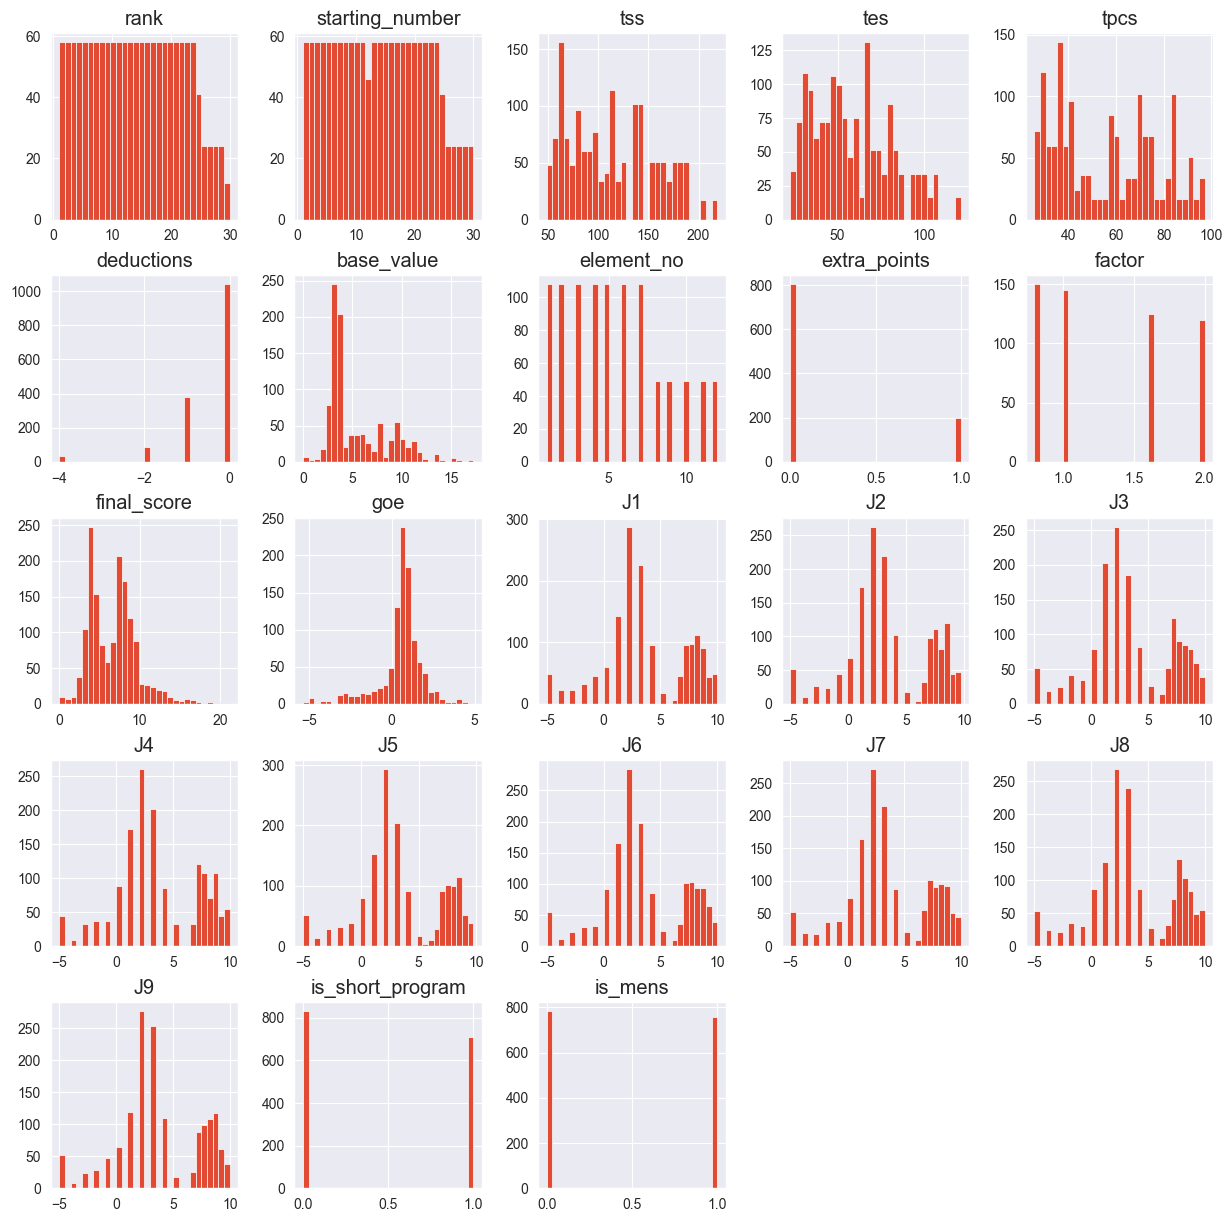

In [44]:
data_df[numeric_cols].hist(figsize=(15, 15), bins=30)
plt.show()

In [42]:
# for col in numeric_cols:
#     fig, axs = plt.subplots(1,3, figsize=(12,6))
#     sns.boxplot(data=data_df, x=col, ax=axs[0])
#     axs[0].set_title(f"Box Plot for {col}")
#     sns.histplot(data=data_df, x=col, bins=30, kde=True, ax=axs[1])
#     axs[1].set_title(f"KDE Plot for {col}")
#     stats.probplot(data_df[col], dist='norm', plot=axs[2])
#     axs[2].set_title(f"Normal QQ Plot for {col}")
#     plt.show()

**Observations:**
- **Judge Scores** 
    - look relatively normal but then have this fat right tail that makes it look bimodal
    - ACTION: Do judges grade right tail skaters higher than their actual skill level should be graded?
    - ACTION: Is the fat right tail a function of windsorizing? Scores can only range in a fixed range and the olympics are mostly a bunch of right tail skaters?
- **Extra Points**
    - most elements are not extra points
    - Question: How does # of extra point elements impact your score?
- **TSS/TES/TPCS**
    - Should remove one of these since they are clearly linear dependent (probably TSS)
    - ACTION: TES / TPCS feature? manually looking at score sheets, seems like people with high TES / TPCS tend to do better?
- **DEDUCTIONS**
    - Almost nobody gets a deduction
    - ACTION: Where in the program do deductions happen?
- **BASE VALUE**
    - Fat right tail
    - ACTION: Where are the high base value elements located in the program?
    - ACTION: How many high base value elements do people do?
    - ACTION: Base Value conditioned on rankings?
    - ACTION: Perhaps the people doing the super hard jumps are the people are way more talented. Does having a high base val mean that judges will score you higher on average?
        - ACTION: Maybe add total base val z-score feature? maybe ordinal ranking of total base val score?
- **GOE**
    - Thin tails, mostly clustered near 0
    - ACTION: How does GOE correlate with Base Value (presumably negative)?
    - ACTION: GOE conditioned on rankings?
- **FACTOR**
    - ACTION: idrk what this is yet 
- **is_mens**
    - ACTION: Group by gender and see what patterns might appear; violin plot etc.

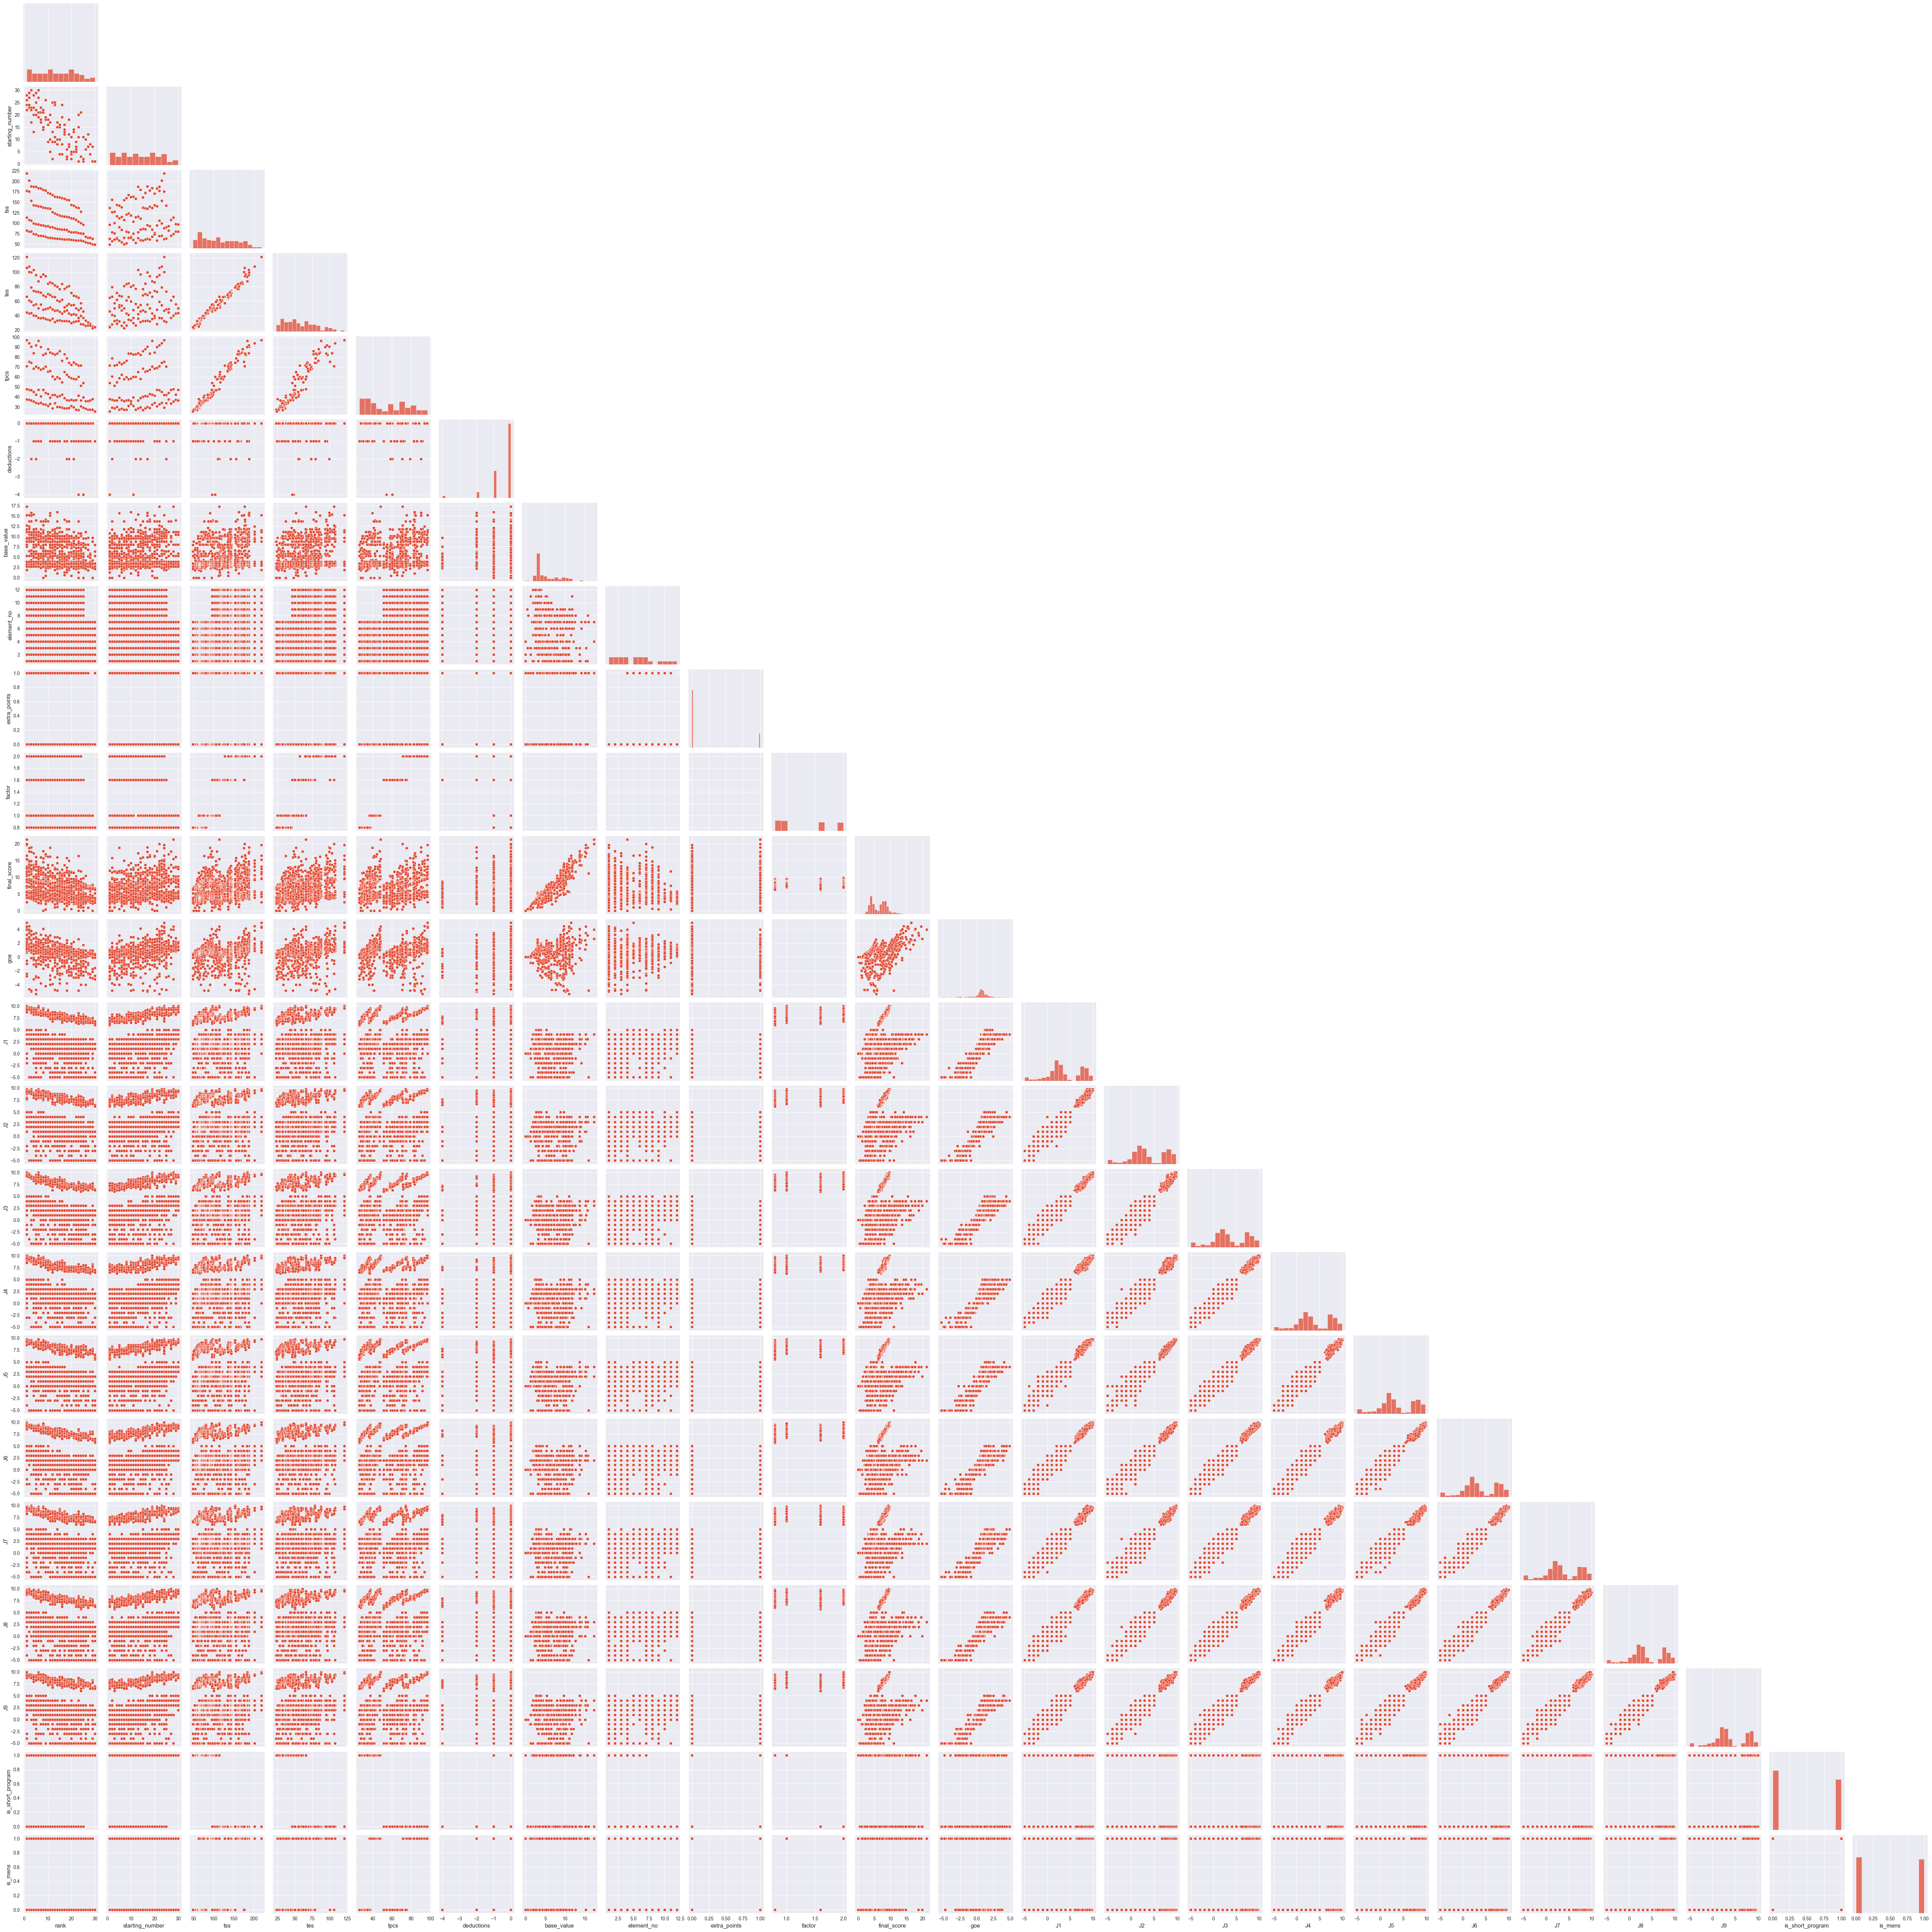

In [45]:
sns.pairplot(data_df[numeric_cols], corner=True)

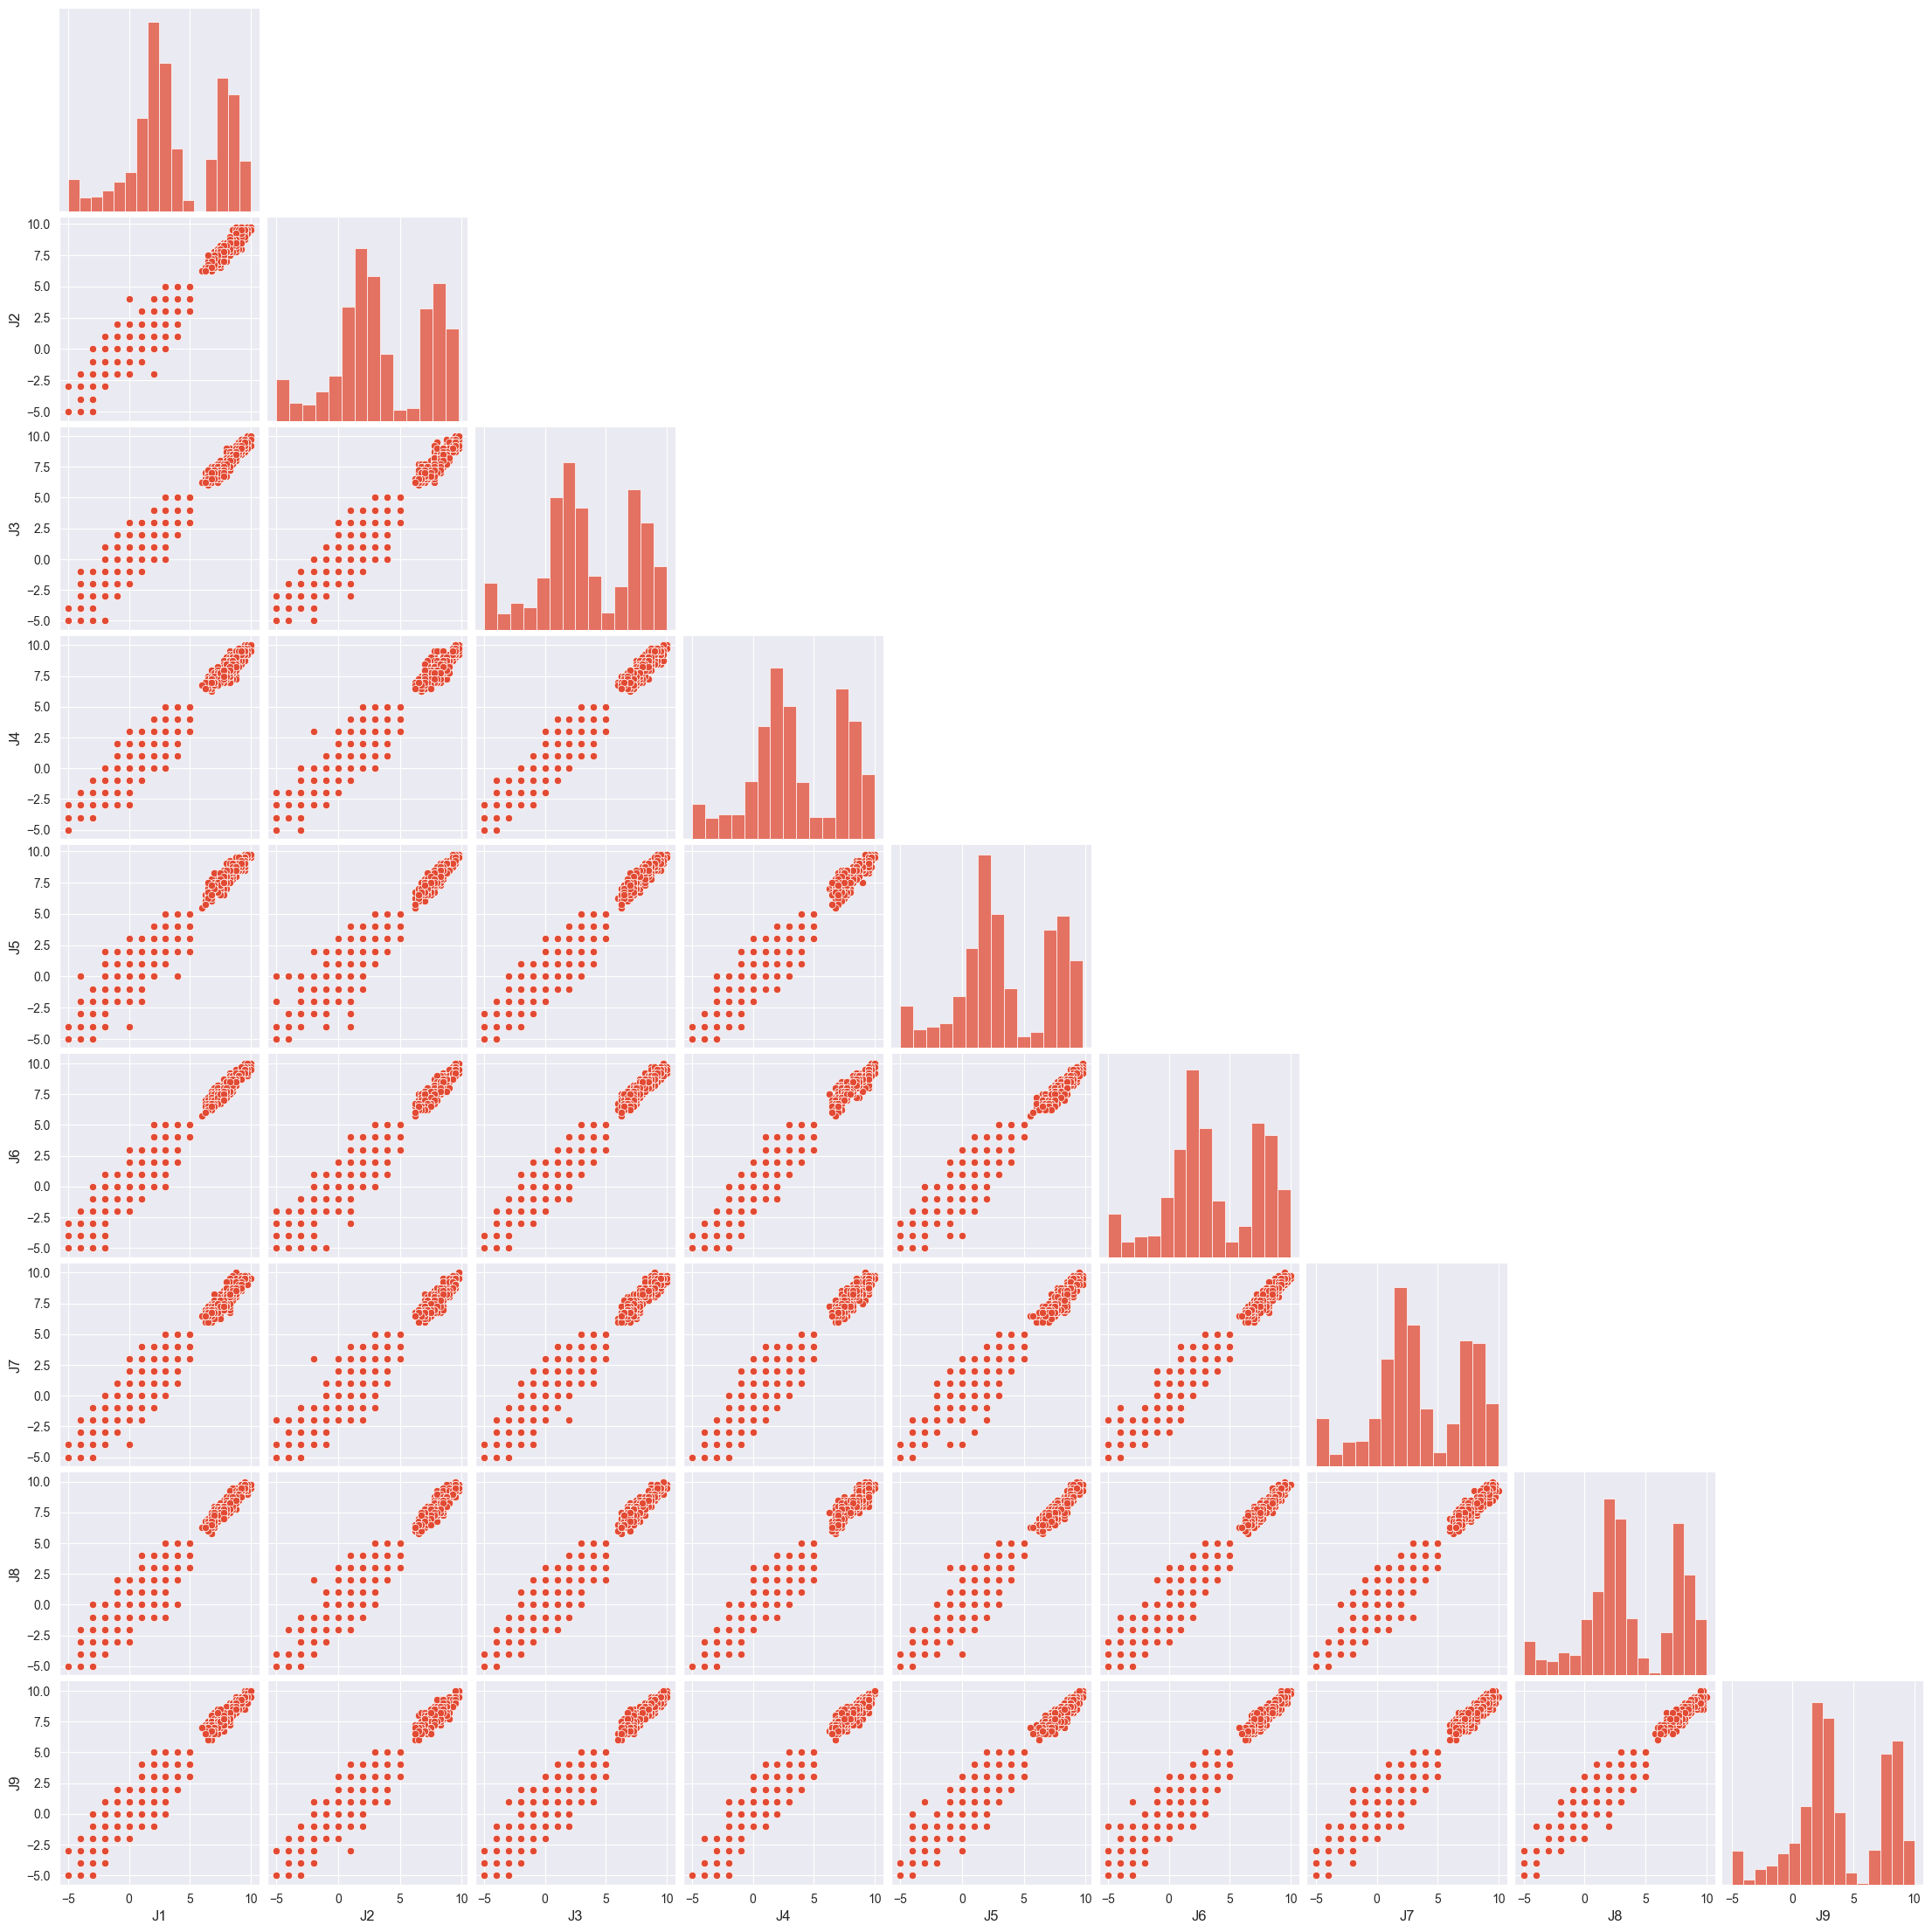

In [47]:
sns.pairplot(data_df[[c for c in numeric_cols if "J" in c]], corner=True)
plt.show()

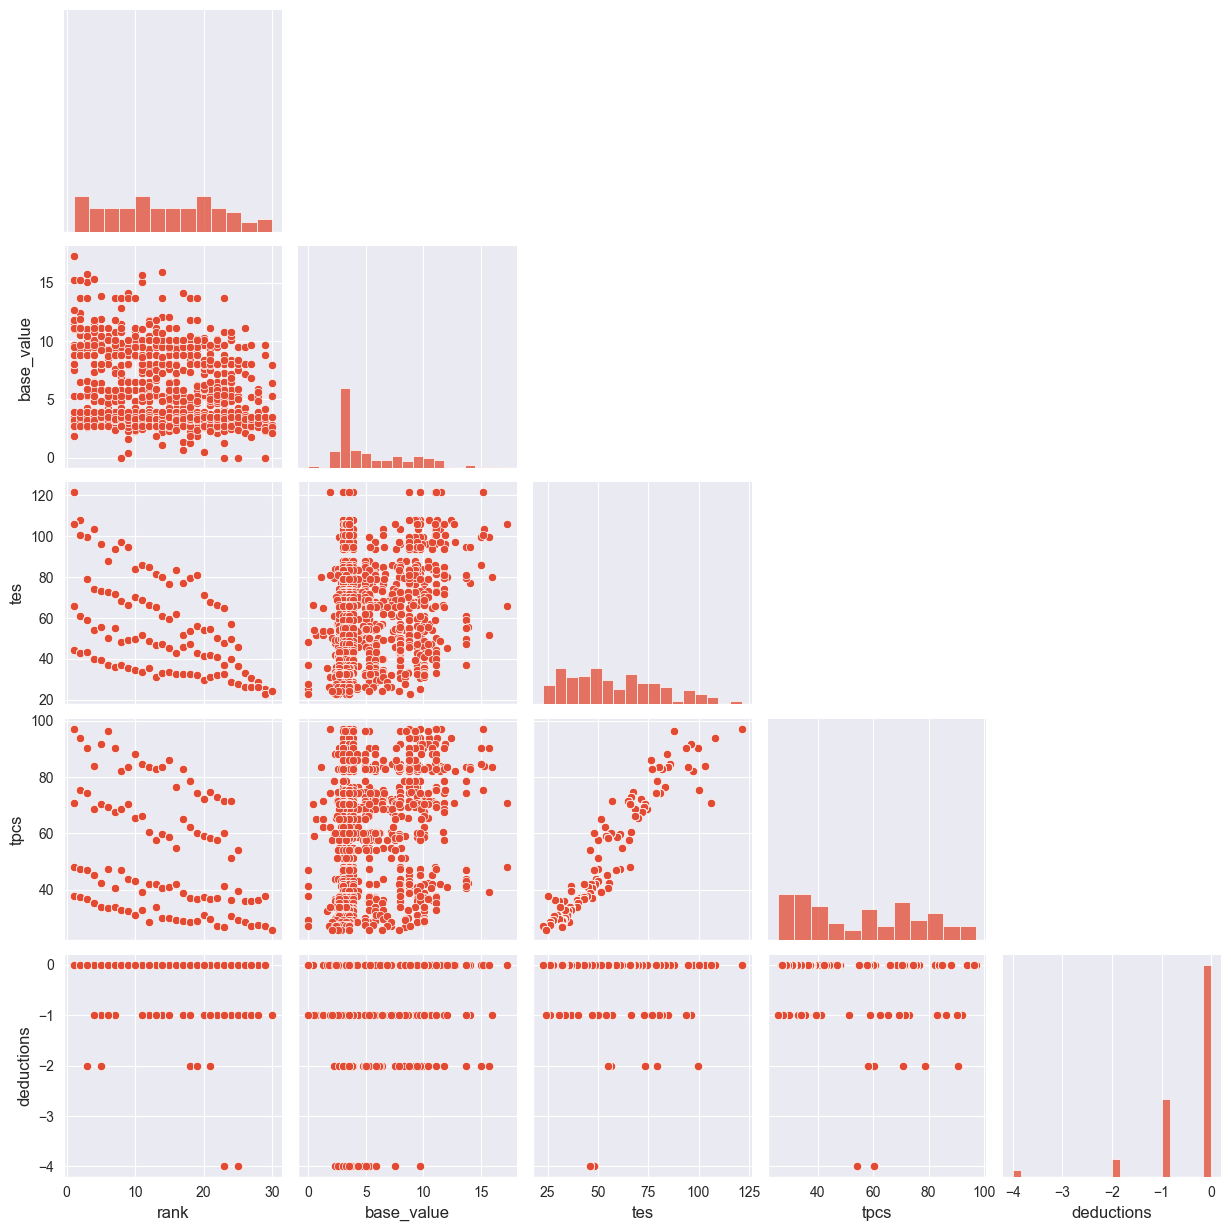

In [51]:
sns.pairplot(data_df[["rank", "base_value", "tes", "tpcs", "deductions"]], corner=True)
plt.show()

**Observations/Actions:**
- **Judge Scores**
    - That right tail on the judges seems to be more related to something else
    - Perhaps a signature move that participants are known for?
    - Perhaps the extra points are baked in already to the judge scores? (ACTION: violinplot comparing the distributions of is_extra)
    - Recalling the permutation trick, the fact that these all look the same makes more sense. They are all drawn from the same mixed distribution.
- **Base Val**
    - Band of base val when compared rank (everyone doing the basic stuff)
    - ACTION: new feature per person is like highest ranked base val component or something
- **TES**
    -Distinct Lines of TES/TPCS/TSS wrt rank
        - ACTION: my guess is that this is women vs men; off inspection top women scorers are scoring much less than top men scorers (DONE)

### Base Val

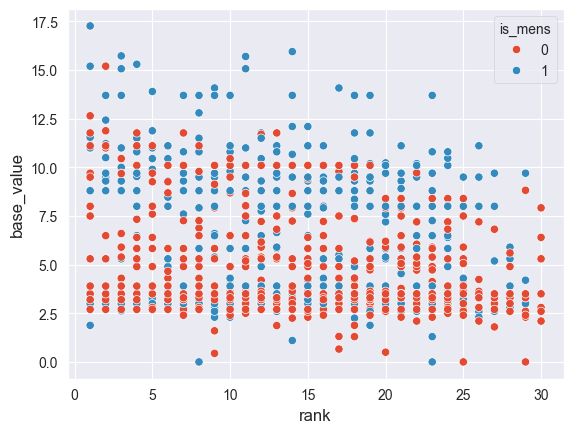

In [56]:
sns.scatterplot(data=data_df, x="rank", y="base_value", hue="is_mens")
plt.show()

### TES

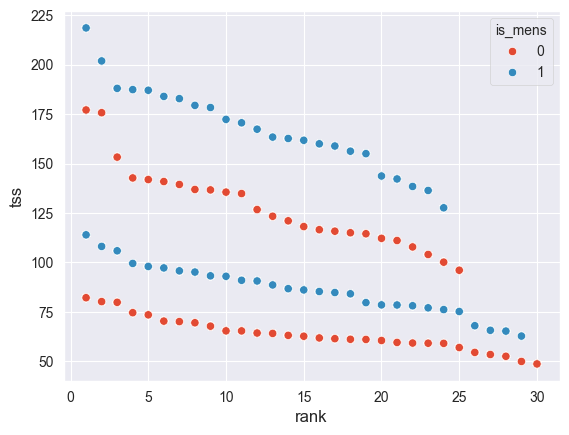

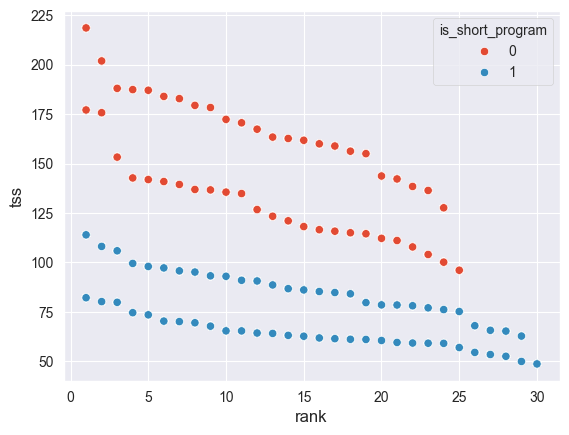

In [55]:
# in tss vs rank plot, the lines are distinct
sns.scatterplot(data=data_df, x="rank", y="tss", hue="is_mens")
plt.show()

# distinct lines are due to gender and due to free vs short program
sns.scatterplot(data=data_df, x="rank", y="tss", hue="is_short_program")
plt.show()

Intuitively this shoudl make sense that the free skate is much higher is score; it literally is longer.

### Gender Split

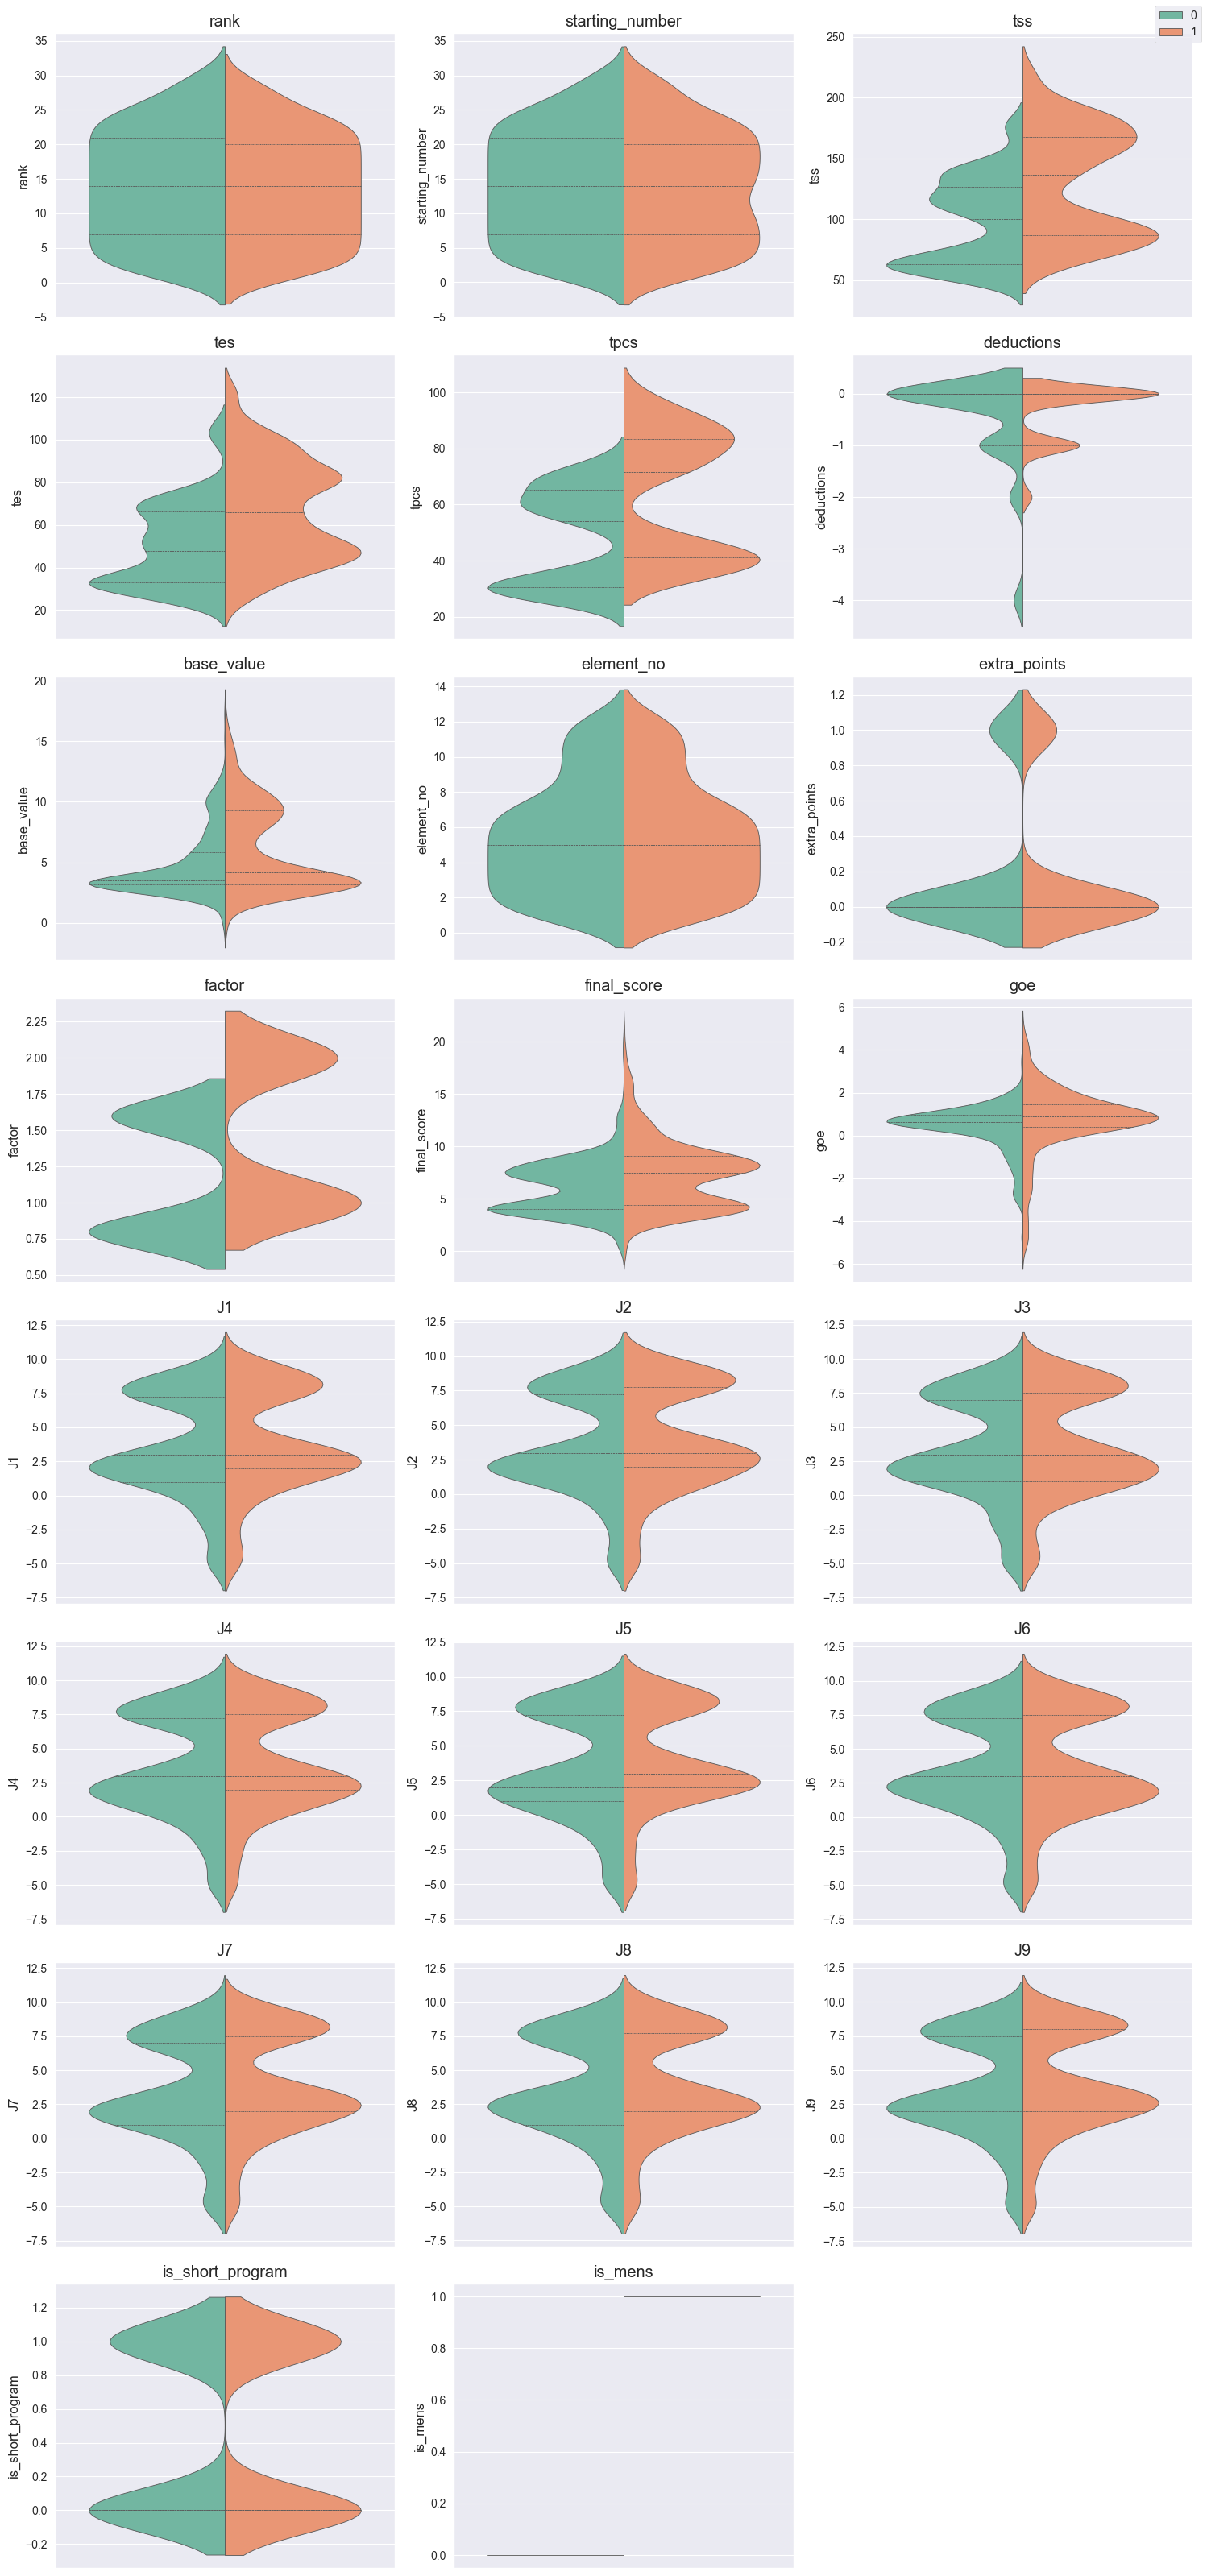

In [61]:
n_cols = 3
n_plots = len(numeric_cols)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # make indexing easy

for i, c in enumerate(numeric_cols):
    sns.violinplot(
        y=c,
        hue="is_mens",
        data=data_df,
        split=True,
        inner="quartile",
        palette="Set2",
        ax=axes[i]
    )
    axes[i].set_title(c)
    axes[i].legend_.remove()  # remove repeated legends

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add one shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.tight_layout()
plt.show()


### Short Program Split

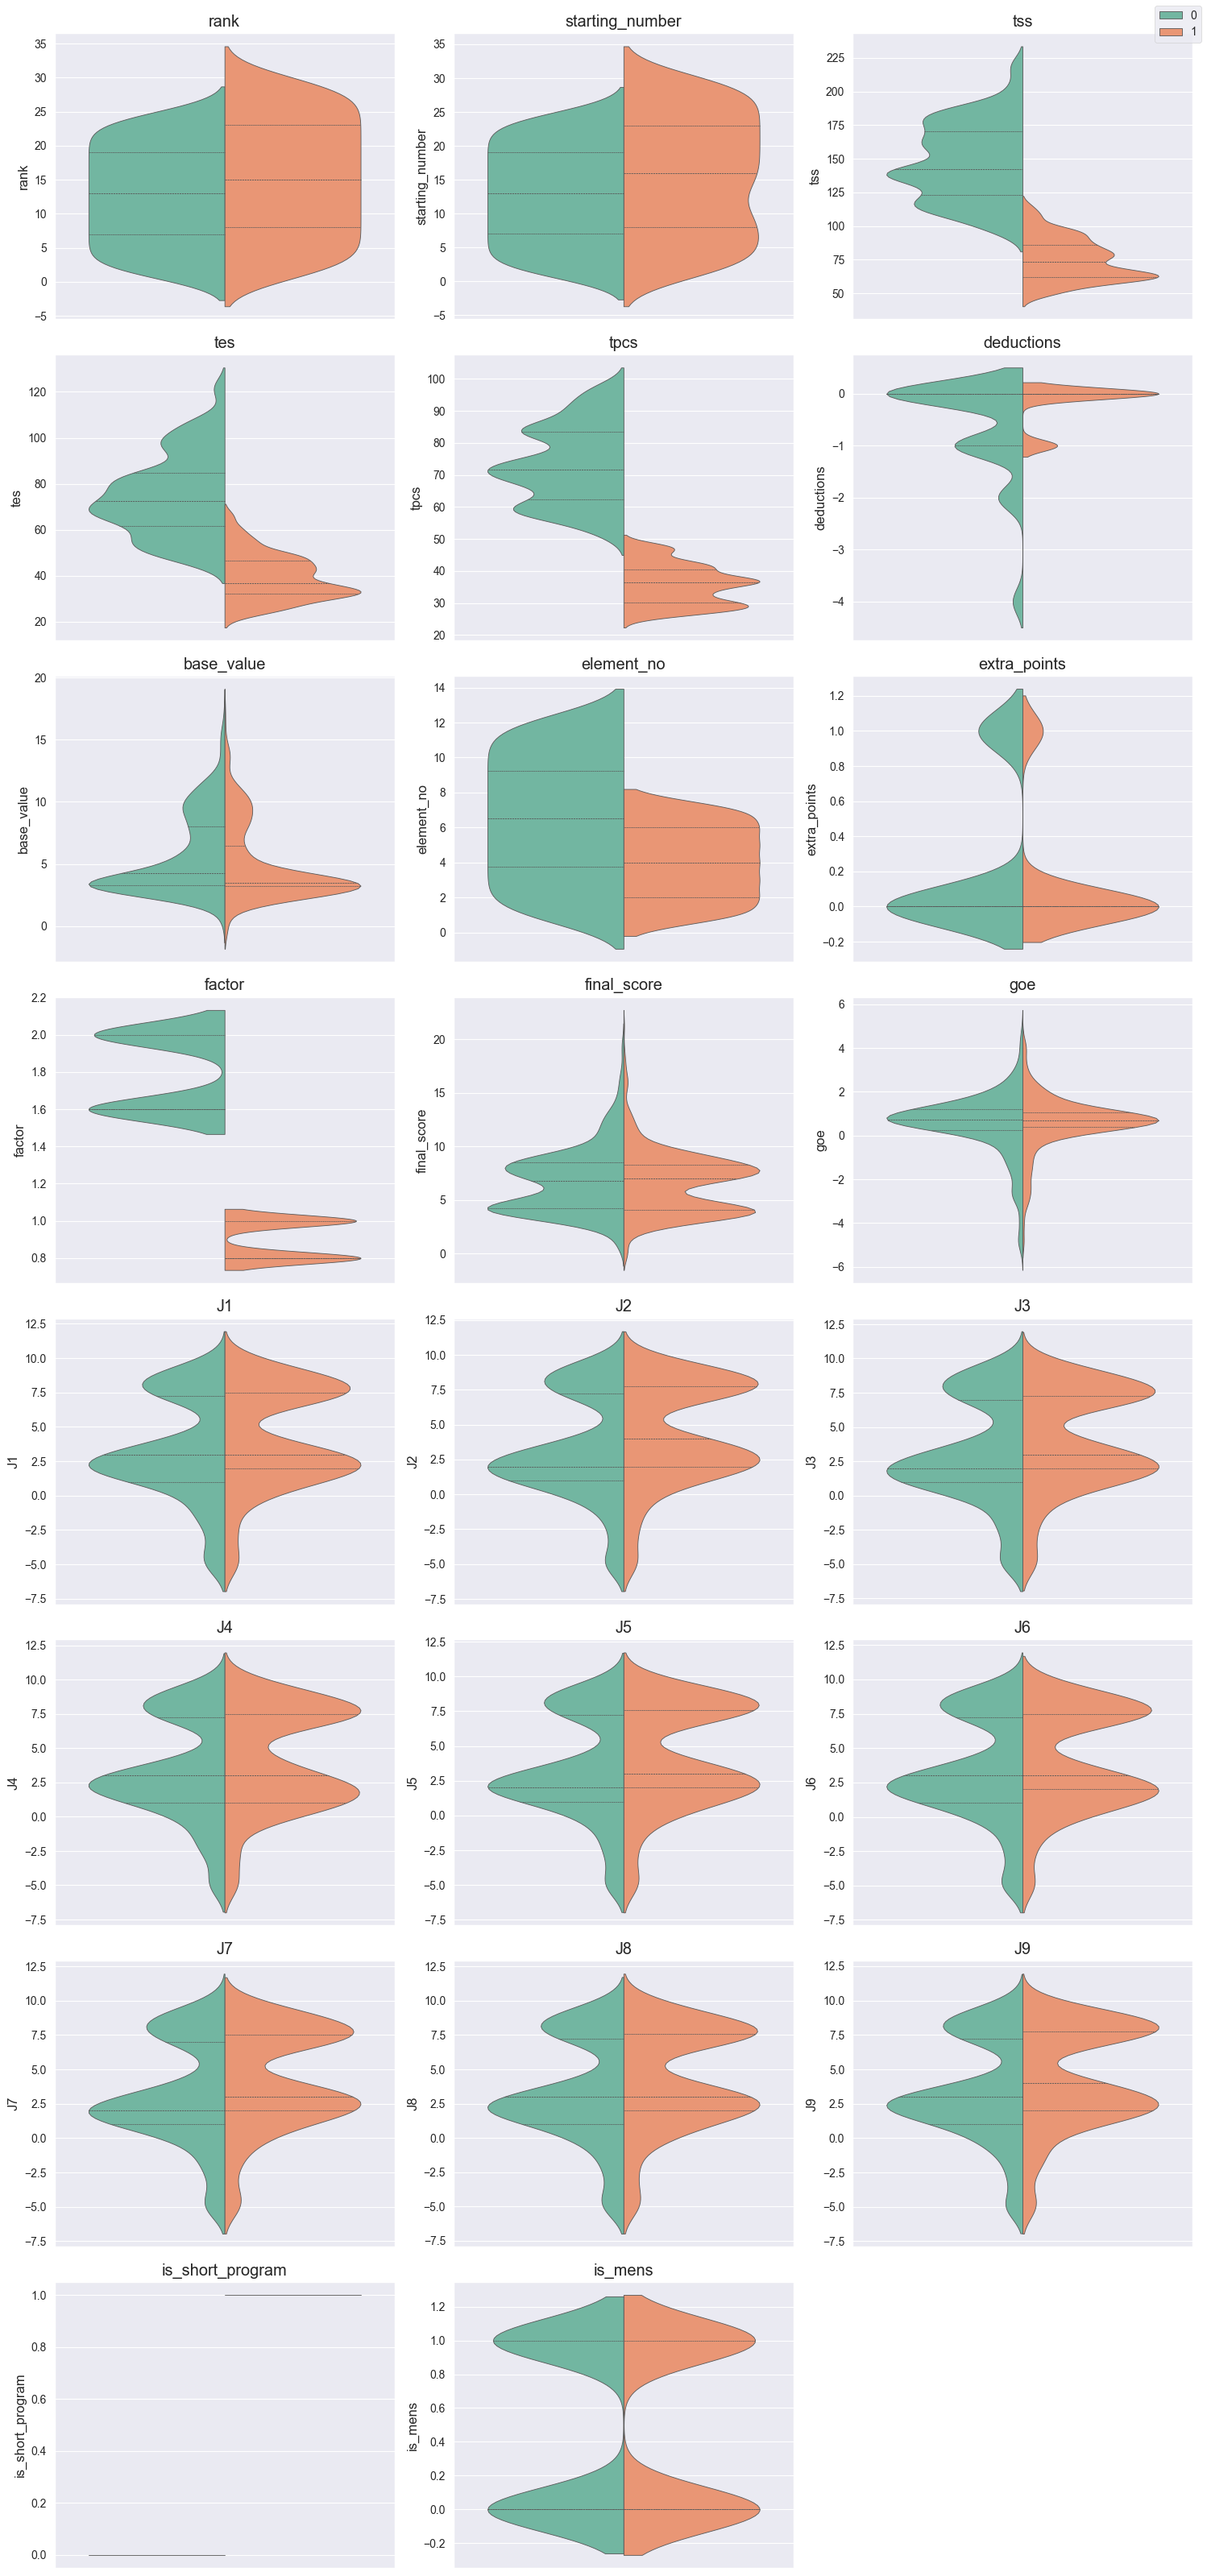

In [62]:
n_cols = 3
n_plots = len(numeric_cols)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # make indexing easy

for i, c in enumerate(numeric_cols):
    sns.violinplot(
        y=c,
        hue="is_short_program",
        data=data_df,
        split=True,
        inner="quartile",
        palette="Set2",
        ax=axes[i]
    )
    axes[i].set_title(c)
    axes[i].legend_.remove()  # remove repeated legends

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add one shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.tight_layout()
plt.show()


### Extra Points Split

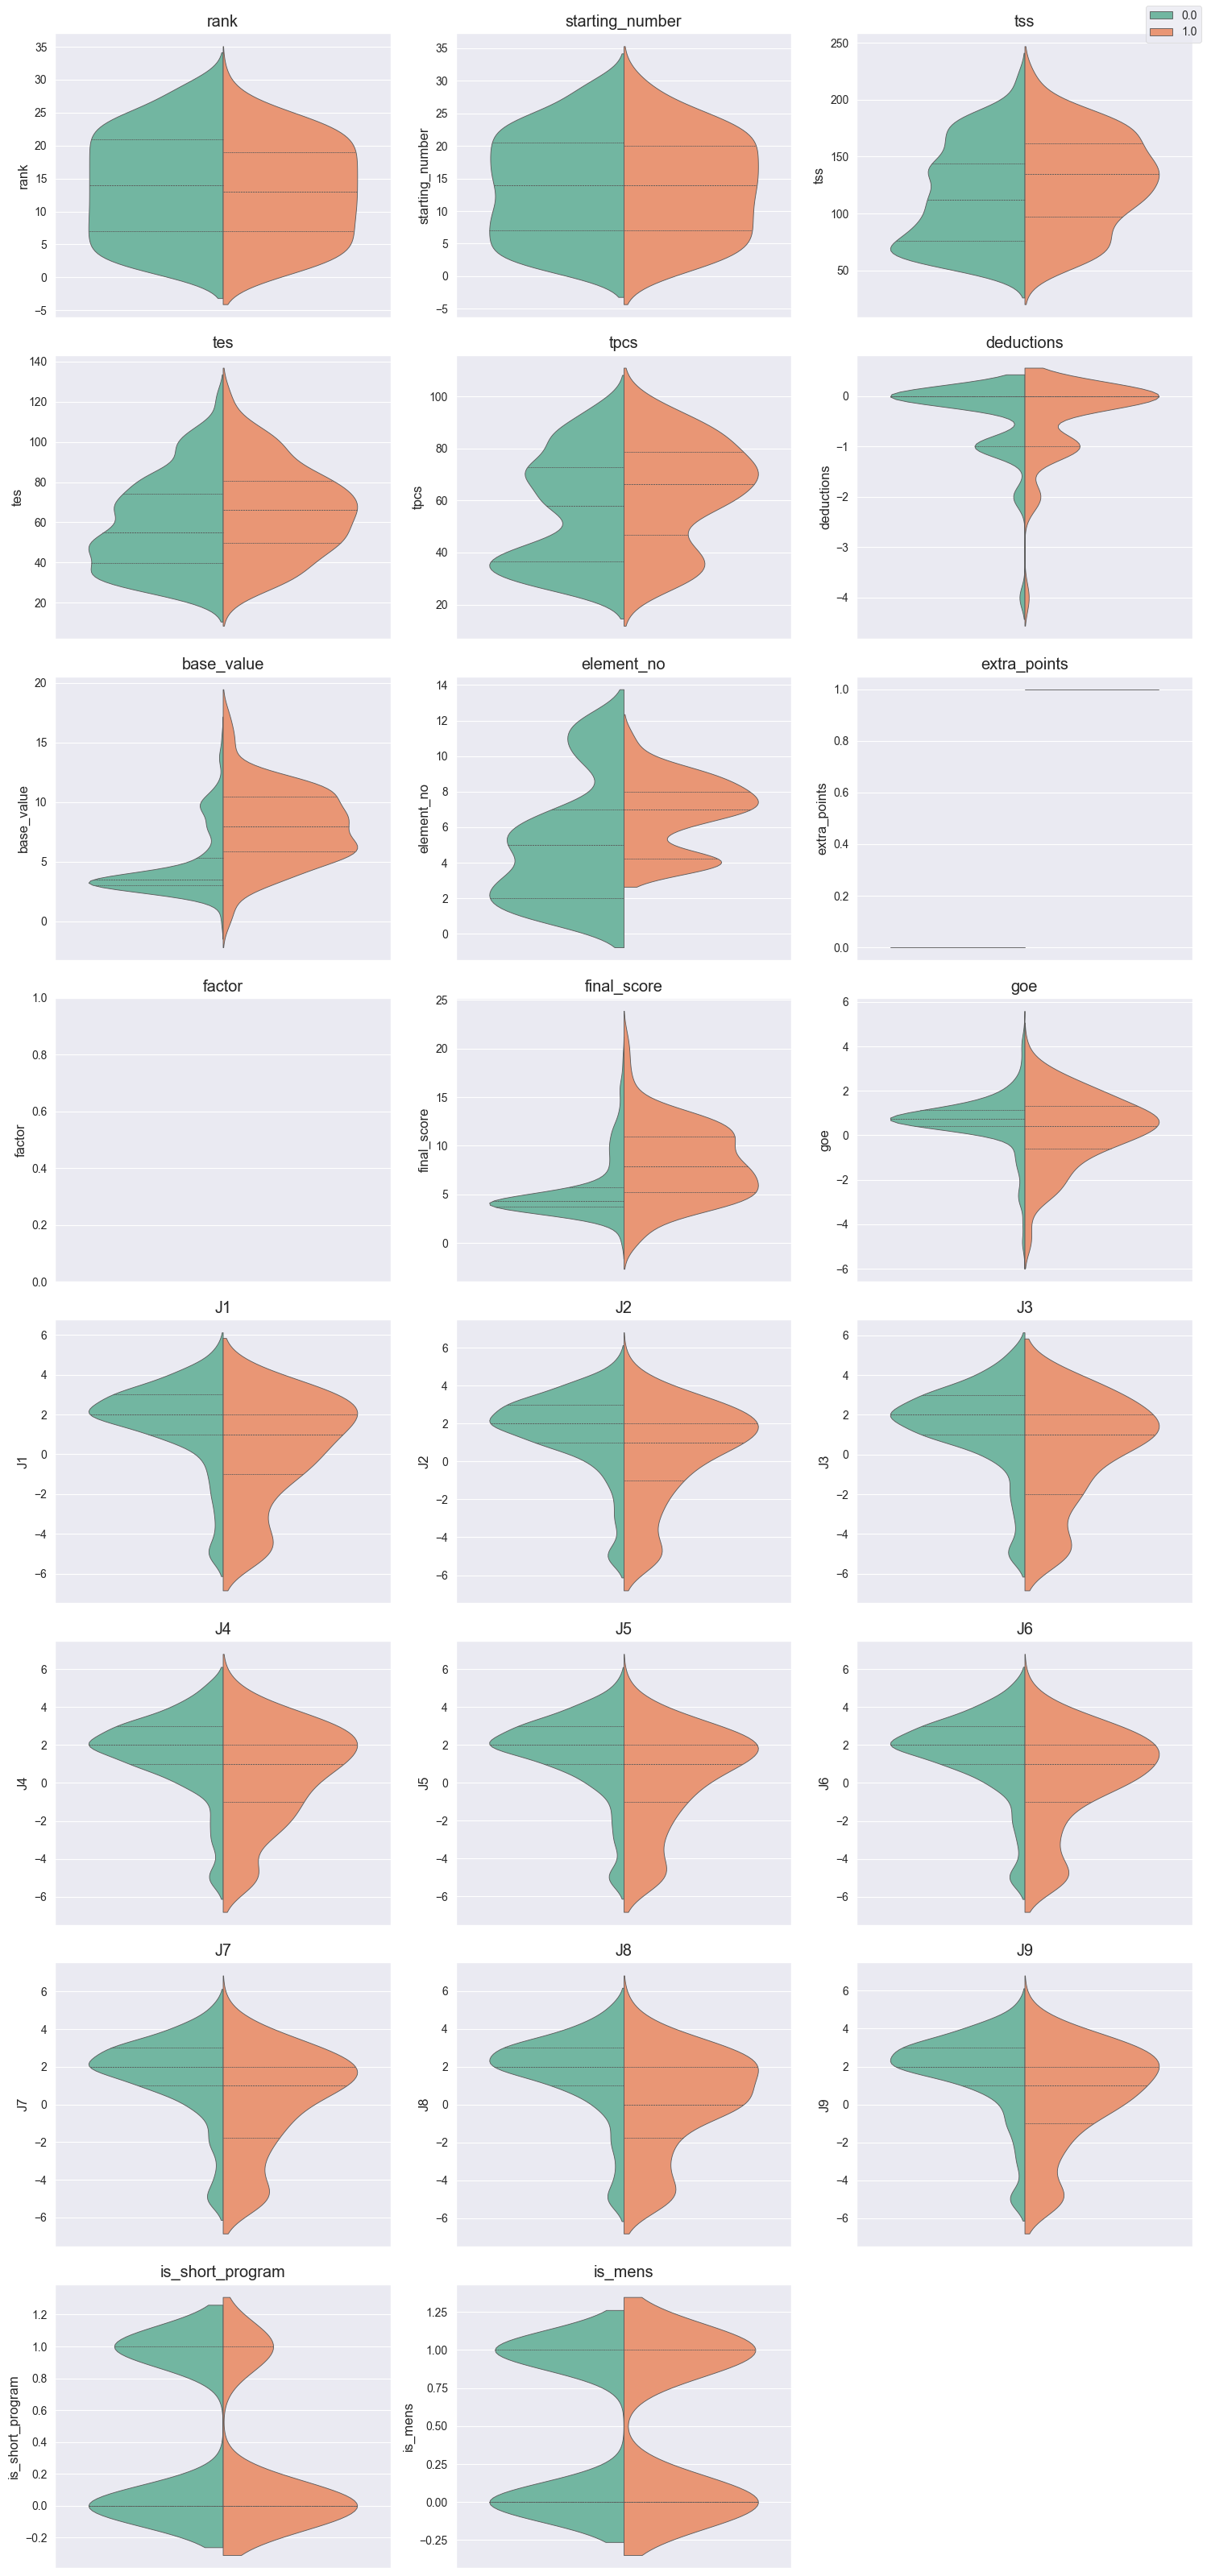

In [70]:
n_cols = 3
n_plots = len(numeric_cols)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # make indexing easy

for i, c in enumerate(numeric_cols):
    sns.violinplot(
        y=c,
        hue="extra_points",
        data=data_df,
        split=True,
        inner="quartile",
        palette="Set2",
        ax=axes[i]
    )
    axes[i].set_title(c)
    axes[i].legend_.remove()  # remove repeated legends

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add one shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right")

plt.tight_layout()
plt.show()


### Final Score

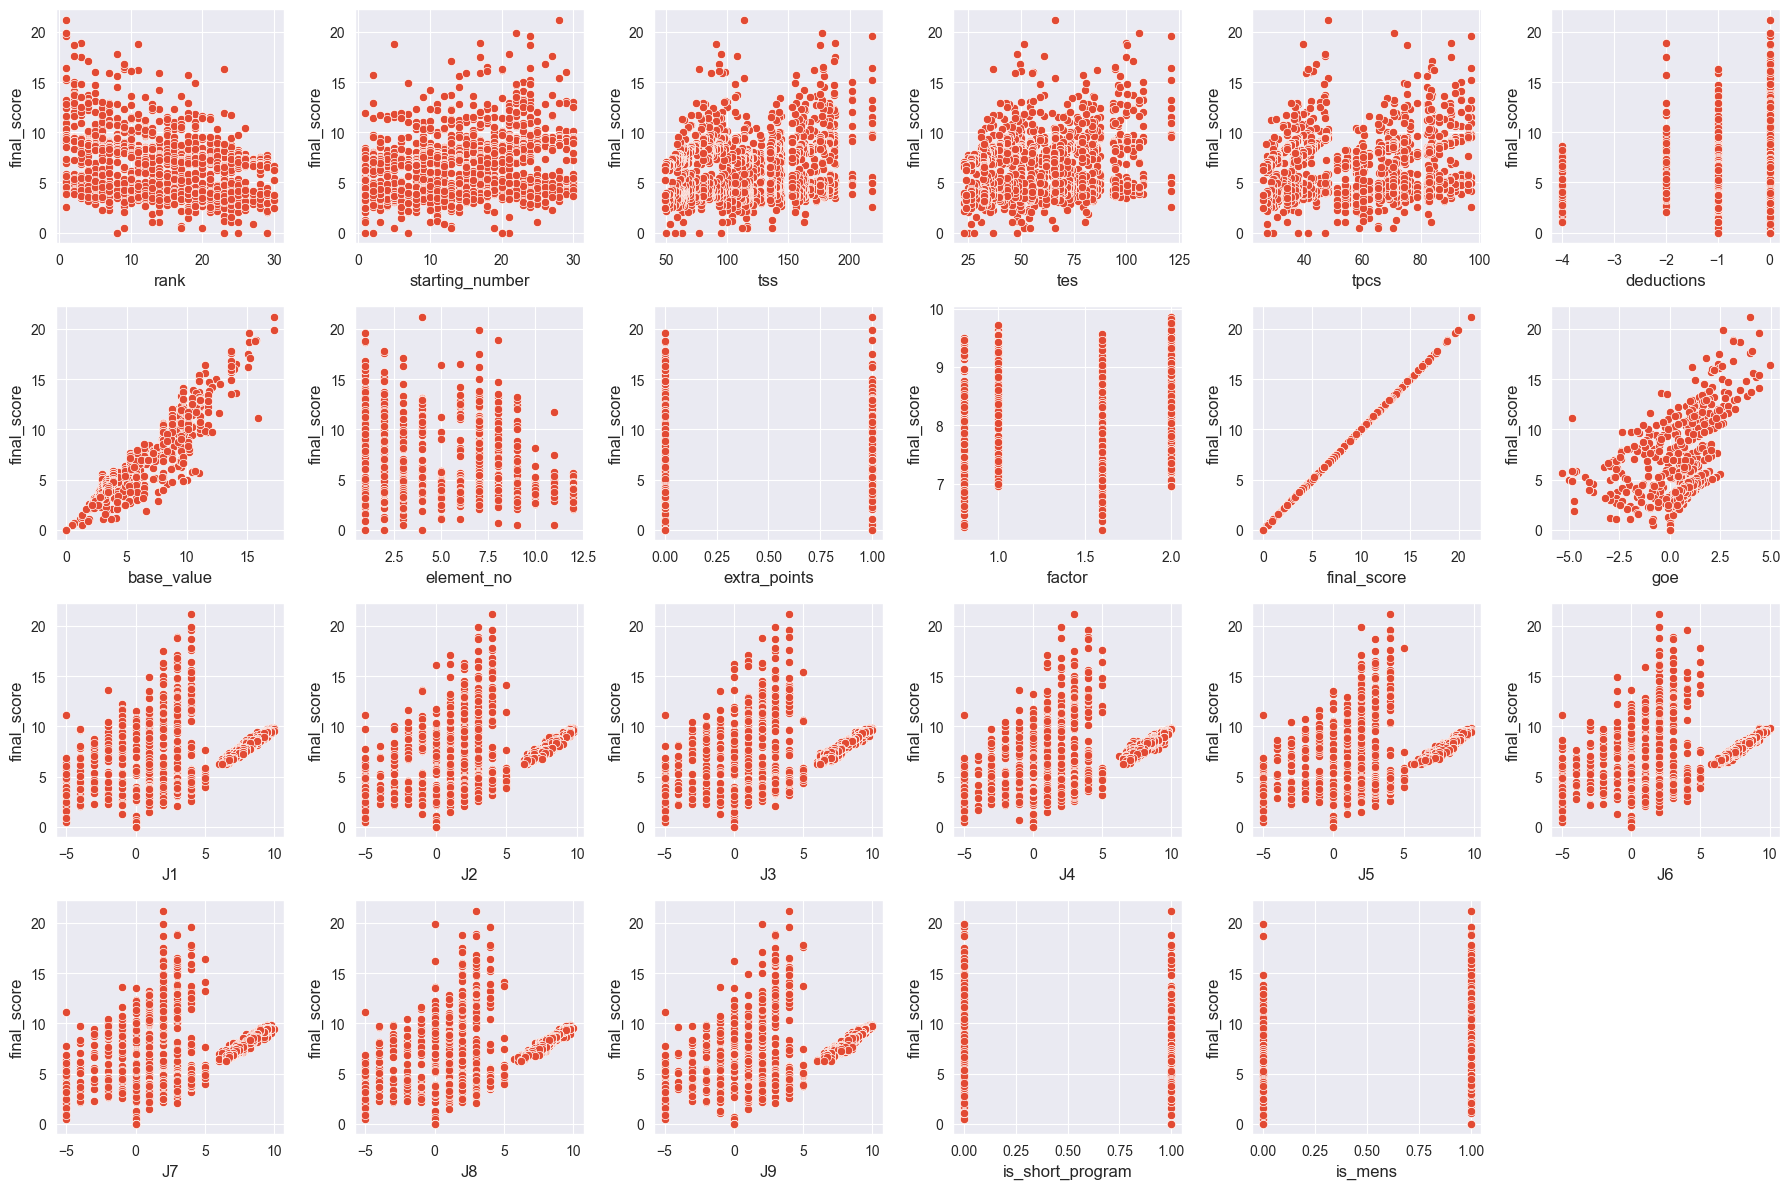

In [68]:
pairplot_list_against_list(data_df, numeric_cols, ["final_score"])

# Interesting Questions

1. Controlling for skill or something like that, is it +ev to do lots of extra jumps and have your hardest jumps be extra points?
2. Do judges grade skilled skaters more favorablely?
3. Do judges grade "easy" elements all the same and then "hard" elements are the differentiating factor? (smth smth variance of so-called easy jumps vs variance of so-called hard jumps?)
4. Reproducing similar study questions like which judges are being dropped, trying to identify judges across the permutations